<h2><center>Projeto 1


MC934B/MO436A

2s 2023
                 
Reinforcement Learning  

Israel Silva | Jorge Frasson - RA 170852 | Juliano Soares | Mario Costa - RA 226496
</center></h2>

<h2><center>Especificação dos problemas</center></h2>
<p align="justify"> As técnicas de aprendizado de máquina estão cada vez mais em uso nos dias de hoje, tais técnicas vem corroborando com a evolução de diversas áreas como: robótica, medicina, engenharia, entre outras; Podemos citar um exemplo na medicina atráves do reconhecimento de cancer de pele como uso deste tipo de tecnologia. Dentro da área de aprendizado uma área que vem sendo utilizada é a técnica de aprendizado de máquina por reforço. Que é o foco do desta atividade proposta.</p>
<p align="justify">A técnica de aprendizado por reforço consiste no treinamento de modelos de aprendizado de máquina que poderiam parecer com treinamento supervisionado -- ser humano interage informando se a decisão tomada está certa ou errada; Porém ao invés de ter um ser humano, a máquina é quem decide e esta decisão é tomada atráves de regras que o desenvolvedor passa para maquina seguir, isso seria como um programa de recompensas, e a maquina só recebe a recompensa quando acerta e pode perder pontos quando erra. Esse modelo faz com que a máquina tome a sua própria decisão tentando maximizar os seus ganhos.</p>
<p align="justify">Este modelo tem sido utilizado em ambientes não determinísticos em que possuem uma alta complexidade nas ações tomadas, como por exemplo, a robótica, que possui um grau de extrema dificuldade em determinar o resultado de um único passo de um robo, quem dirá prever todas as ações externas que ele pode estar sofrendo como um empurrão.   </p>
<p align="justify">Para aplicar as técnicas propostas pelo atividade, criamos um desafio que consiste em, um ambiente com um espaço limitado a X por Y (pode ser configurado), que permite a inserção de barreiras que não podem ser transpostas. O ambiente também vai possuir uma origem e um destino. A  distância (origem/destino) é que deverá ser percorrido por um determinado bloco, que vamos chamar de Bob. 
O Bob deverá aprender o caminho, porém o Bob deverá passar por desafios em 2 tipos de ambientes o deterministico e o estocástico. 
Para isso o Bob deverá passar um treinamento, quando a execução for no mesmo ambiente do treinamento iremos chamar de deterministico e quando a execução for em um outro ambiente com barreiras desconhecidas, iremos chamar de estocástico. 
Sendo assim o objetivo de Bob é: encontrar a  melhor política e configuração que irá levar Bob para casa com o menor número de passos.</p>
<p align="justify">O trabalho proposto tem como objetivo explorar 3 técnicas: Monte Carlo, Qlearning, Sarsa, com aproximador de função e sem e montar uma avaliação entre as técnicas utilizadas tendo como base de descoberta o ambiente descrito acima. Para que sejam respondidas 4 questões principais apresentadas abaixo:</p>
<p align="justify">1 - Vantagens e desvantagens do bootstraping no projeto proposto?</p>
<p align="justify">2 - Como a função de recompensa influencia na qualidade da solução. O seu grupo conseguiu concretizar a política esperada dada a função de política definida?</p>
<p align="justify">3 - Como a função de aproximação influenciou no seu projeto e quais foram as vantegens e desvantagens de utiliza-lás?</p>
<p align="justify">4 - Compare os resultados e os seus ambientes? Quais tiveram mais dificuldades de aprender?</p>

<h2><center>Entrada de dados</center></h2>
<p align="justify">A solução apresentada para executar as atividades propostas pelo trabalho foram: Python e algumas bibliotécas apresentadas no tópico de instalação das bibliotécas, caso os arquivos abaixo não estejam diponíveis na raiz o mesmo deve ser criado (raiz com e sub diretórios): </p>
<pre>
-> results
     |
     --> MonteCarloAgent
     --> QLearningAgent
     --> SARSAgent. 
</pre>
<p align="justify">Estes diretórios serão utilizados para armazena os gráficos, caso a opção de salvar gráficos esteja habilitado.</p>
<p align="justify">Um outro ponto importante que merece ser destacado, é que, foram executadas diversas experiências de ajustes nas variáveis alfa, gamma e epsilon antes de escolhermos e fixarmos estes grupos de variáveis apresentadas nesta atividade.</p>
<p align="justify">O sistema está arquitetado de forma que para executar, basta que o usuário apenas siga a sequência execução das funções propostas.</p>

# Códigos e parâmetros utilizados

## Ambiente e funções utilitárias

Instalação das Bibliotecas

In [22]:
# !pip install gymnasium
# !pip install numpy
# !pip install pygame
# !pip install random
# !pip install tqdm
# !pip install matplotlib
# !pip install pandas
# !pip install tabulate

Importação das Bibliotecas

In [2]:
%matplotlib inline

import gymnasium as gym
import numpy as np
import pygame
import matplotlib.pyplot as plt
import time
import sys
import math
import pandas as pd
import os
from ast import literal_eval
from tabulate import tabulate

Ambiente do labirinto

In [3]:
class MazeGameEnv(gym.Env):
    def __init__(self, maze):
        super(MazeGameEnv, self).__init__()
        self.maze = np.array(maze)
        self.start_pos = tuple(np.argwhere(self.maze == 'S')[0])
        self.goal_pos = tuple(np.argwhere(self.maze == 'G')[0])
        self.current_pos = self.start_pos
        self.num_rows, self.num_cols = self.maze.shape

        # Define ação como Discrete com 4 ações (cima, baixo, esquerda, direita)
        self.action_space = gym.spaces.Discrete(4)

        # Defina o espaço de observação como uma tupla com o número de linhas e colunas
        self.observation_space = gym.spaces.Tuple((gym.spaces.Discrete(self.num_rows), gym.spaces.Discrete(self.num_cols)))
    
        # Define atraso de renderização (em ms)
        self.delay = 0

        # Defina cores
        self.WHITE = (255, 255, 255)
        self.GREEN = (0, 255, 0)
        self.RED = (255, 0, 0)
        self.BLACK = (0, 0, 0)
        self.PURPLE = (255, 0, 255)
        self.BLUE = (0, 0, 255)
        self.GOLD = (255, 215, 0)
        self.GRAY = (128, 128, 128)

    def InitializePygame(self):
        # Inicialize o ambiente Pygame
        pygame.init()

        # Defina o tamanho da célula e a largura e altura da tela
        self.cell_size = 50
        self.screen_width = self.num_cols * self.cell_size
        self.screen_height = self.num_rows * self.cell_size
        self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))

    def reset(self, num_obstacles = 0, fixed_start_pos = None):
        self.reset_obstacles(num_obstacles)
        if fixed_start_pos is not None:
            row, col = fixed_start_pos
        else:
            row, col = np.random.randint(0, self.num_rows), np.random.randint(0, self.num_cols)
            while self.maze[row, col] in ['#', 'G']:  # Garante que a posição inicial não é um obstáculo ou a posição final
                row, col = np.random.randint(0, self.num_rows), np.random.randint(0, self.num_cols)
        self.maze[self.start_pos] = '.'  # Limpa a posição inicial antiga
        self.start_pos = (row, col)
        self.maze[row, col] = 'S'  # Define a nova posição inicial
        self.current_pos = self.start_pos
        return self.current_pos

    def reset_obstacles(self, num_obstacles = 0):
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                if self.maze[row, col] == 'R':
                    self.maze[row, col] = '.'

        for _ in range(num_obstacles):
            row, col = np.random.randint(0, self.num_rows), np.random.randint(0, self.num_cols)
            while self.maze[row, col] in ['S', 'G', '#','R']:
                row, col = np.random.randint(0, self.num_rows), np.random.randint(0, self.num_cols)
            self.maze[row, col] = 'R'

    def step(self, action, reward = 1):
        old_pos = self.current_pos
                
        if action == 0:  # Cima
            self.move('up')
        elif action == 1:  # Baixo
            self.move('down')
        elif action == 2:  # Esquerda
            self.move('left')
        elif action == 3:  # Direita
            self.move('right')

        new_pos = self.current_pos

        # Recompensas e penalidades
        if new_pos == self.goal_pos:
            reward = 10  # Recompensa por atingir o objetivo
            done = True
        elif new_pos == old_pos:
            reward = -0.01  # Penalidade por bater em um obstáculo ou parede
            done = False
        else:
            reward = -0.001  # Penalidade por cada movimento
            done = False

        info = {}

        return new_pos, reward, done, info

    def move(self, action):
        new_pos = list(self.current_pos)

        if action == 'up':
            new_pos[0] -= 1
        elif action == 'down':
            new_pos[0] += 1
        elif action == 'left':
            new_pos[1] -= 1
        elif action == 'right':
            new_pos[1] += 1

        new_pos = tuple(new_pos)

        if self.is_valid_position(new_pos[0], new_pos[1]):
            self.current_pos = new_pos

    def is_valid_position(self, row, col):
        return 0 <= row < self.num_rows and 0 <= col < self.num_cols and self.maze[row, col] != '#' and self.maze[row, col] != 'R'


    def render(self, path=None):
        self.screen.fill(self.WHITE)
        self.draw_maze(path)
        pygame.display.update()
        if self.delay > 0:
            pygame.time.wait(self.delay)
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
            elif event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:
                    pygame.quit()
                    sys.exit()

    def play_path(self, path, delay=0.5):
        for position in path:
            self.current_pos = position
            self.render(path = path)
            time.sleep(delay)
            
    def draw_star(self, surface, color, center, points, outer_radius, inner_radius):
        def get_point(index):
            angle_offset = math.pi / 2  # Ajuste de orientação
            radius = outer_radius if index % 2 == 0 else inner_radius
            angle = index * (2 * math.pi / (2 * points)) - angle_offset
            return center[0] + radius * math.sin(angle), center[1] - radius * math.cos(angle)

        star_points = [get_point(i) for i in range(2 * points)]
        pygame.draw.polygon(surface, color, star_points)

    def draw_maze(self, path = None):
        for row in range(self.num_rows):
            for col in range(self.num_cols):
                cell_left = col * self.cell_size
                cell_top = row * self.cell_size

                # Desenha o quadrado branco com borda preta
                pygame.draw.rect(self.screen, self.BLACK, (cell_left, cell_top, self.cell_size, self.cell_size), 1)

                if self.maze[row, col] == '#' or self.maze[row, col] == 'R':
                    pygame.draw.rect(self.screen, self.BLACK, (cell_left, cell_top, self.cell_size, self.cell_size))
                elif self.maze[row, col] == 'S':
                    pygame.draw.circle(self.screen, self.GREEN, (cell_left + self.cell_size // 2, cell_top + self.cell_size // 2), self.cell_size // 2 - 5)
                elif self.maze[row, col] == 'G':
                    self.draw_star(self.screen, self.GOLD, (cell_left + self.cell_size // 2, cell_top + self.cell_size // 2), 5, self.cell_size // 2, self.cell_size // 4)

        if path:
            for i in range(len(path)-1):
                start = path[i]
                end = path[i+1]
                self.draw_line(start, end)

        current_row, current_col = self.current_pos
        pygame.draw.rect(self.screen, self.PURPLE, (current_col * self.cell_size + 5, current_row * self.cell_size + 5, self.cell_size - 10, self.cell_size - 10))

    def draw_line(self, start, end):
        start_x = start[1] * self.cell_size + self.cell_size // 2
        start_y = start[0] * self.cell_size + self.cell_size // 2
        end_x = end[1] * self.cell_size + self.cell_size // 2
        end_y = end[0] * self.cell_size + self.cell_size // 2

        pygame.draw.line(self.screen, self.BLUE, (start_x, start_y), (end_x, end_y), 2)

    def draw_arrows(self, Q):
        arrow_image = pygame.image.load('assets/arrow.png')  # Carrega a imagem da seta
        arrow_image = pygame.transform.scale(arrow_image, (self.cell_size // 2, self.cell_size // 2))  # Redimensiona para caber na célula

        for row in range(self.num_rows):
            for col in range(self.num_cols):
                state = (row, col)
                if self.maze[row][col] in ['.', 'R', 'S']:  # Não desenhar em '#', 'S' ou 'G'
                    best_action = max(Q[state], key=Q[state].get)
                    center = (col * self.cell_size + (self.cell_size // 2 // 2), row * self.cell_size + (self.cell_size // 2 // 2))

                    if best_action == 0:  # Cima
                        rotated_image = pygame.transform.rotate(arrow_image, 90)
                    elif best_action == 1:  # Baixo
                        rotated_image = pygame.transform.rotate(arrow_image, -90)
                    elif best_action == 2:  # Esquerda
                        rotated_image = pygame.transform.rotate(arrow_image, 180)
                    elif best_action == 3:  # Direita
                        rotated_image = arrow_image  # Não precisa rotacionar

                    self.screen.blit(rotated_image, center)  # Desenha a imagem rotacionada

    def close(self):
        pygame.quit()


Função para criação do espaço do labirinto a ser analisado

In [4]:
mazes = [
    [
    ['S', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '#', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '#', '.'],
    ['.', '.', '.', '.', '#', '.', '.', '.', '.', '.'],
    ['.', '#', '#', '#', '#', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '#', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '#', '.', '.', '.', '.', '.', '.', '.', 'G'],
    ],
    [
    ['S','.','.','.','.','.'],
    ['.','.','.','#','.','.'],
    ['.','.','.','#','.','.'],
    ['.','.','.','#','.','.'],
    ['.','#','#','#','.','.'],
    ['.','.','.','.','.','G']
    ],
    [
    ['S','.','#','.','#','.'],
    ['.','.','.','.','#','.'],
    ['.','#','#','.','#','.'],
    ['.','#','#','.','#','.'],
    ['.','.','.','.','#','.'],
    ['#','.','.','.','.','G']
    ],
    [
    ['S','.','.','.','.','.'],
    ['.','.','.','.','.','.'],
    ['.','.','#','#','.','.'],
    ['.','.','#','#','.','.'],
    ['.','.','.','.','.','.'],
    ['.','.','.','.','.','G']
    ],
    [
    ['.','.','.','.','.','.','.','.'],
    ['.','S','.','.','.','.','.','.'],
    ['.','.','.','.','.','.','.','.'],
    ['.','.','.','#','#','.','.','.'],
    ['.','.','.','#','#','.','.','.'],
    ['.','.','.','.','.','.','.','.'],
    ['.','.','.','.','.','.','G','.'],
    ['.','.','.','.','.','.','.','.']
    ],
    [
    ['.','.','.','.','.','.','.','.'],
    ['.','.','.','.','.','.','.','.'],
    ['.','#','#','.','#','#','.','.'],
    ['.','#','#','.','#','#','.','.'],
    ['.','.','.','G','#','.','.','.'],
    ['.','#','#','.','#','#','.','.'],
    ['.','#','#','.','#','#','.','.'],
    ['.','.','.','.','.','.','.','S']
    ],
    [
    ['S', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '#', '#', '#', '#', '#', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '#', '#', '#', '#', '#', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '#', '#', '#', '#', '#', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '#', '#', '#', '#', '#', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '#', '#', '#', '#', '#', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'],
    ['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'G'],
    ]
]

Funções utilitárias para geração de relatório e análises

In [32]:
def showQ(agent):
    agent.env.InitializePygame()
    agent.env.render()
    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_ESCAPE:  # Tecla ESC
                    running = False

        if running:  # Desenha apenas se a janela ainda estiver aberta
            agent.env.draw_arrows(agent.Q)
            pygame.display.update()
        else:
            agent.env.close()
            break
        
def execute_optimal_policy(agent, max_steps=100, start_pos=None):
    state = agent.env.reset(num_obstacles=0, fixed_start_pos=start_pos)
    path = [state]  # Iniciar o caminho com o estado inicial
    agent.env.InitializePygame()
    agent.env.render(path=path)  # Passa o caminho atual para a função render
    step_count = 0
    done = False
    while not done and step_count < max_steps:
        action = max(agent.Q[state], key=agent.Q[state].get)
        next_state, reward, done, _ = agent.env.step(action)
        path.append(next_state)  # Adicionar o novo estado ao caminho
        agent.env.render(path=path)  # Renderizar novamente com o caminho atualizado
        state = next_state
        step_count += 1
        time.sleep(0.05)
        if done:
            agent.env.close()
            break
    agent.env.close()

def extract_data(episodes_data):
    rewards = [info['reward'] for episode, info in episodes_data.items()]
    steps = [info['steps'] for episode, info in episodes_data.items()]
    return rewards, steps

def plot_learning_curve(rewards, agent, show_plots, save_plots, num_obstacles):
    """
    Plota a curva de aprendizado.

    Args:
    - rewards (list): Lista de recompensas totais por episódio.
    - title (str): Título do gráfico.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Total Reward per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title(f'Learning Curve - {agent.__class__.__name__}')
    plt.grid(True)
    plt.legend()
    
    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/learning_curve_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()

def plot_steps_per_episode(steps, agent, show_plots, save_plots, num_obstacles):
    """
    Plota o número de passos por episódio.

    Args:
    - steps (list): Lista do número de passos por episódio.
    - title (str): Título do gráfico.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(steps, label='Steps per Episode')
    plt.xlabel('Episodes')
    plt.ylabel('Number of Steps')
    plt.title(f'Steps per Episode - {agent.__class__.__name__}')
    plt.grid(True)
    plt.legend()
    
    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/steps_per_episode_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')
    
    if show_plots:
        plt.show()
    else:
        plt.close()
        
def plot_q_value_heatmap(agent, show_plots, save_plots, num_obstacles):
    """
    Plota o mapa de calor dos valores Q.

    Args:
    - Q (dict): Dicionário dos valores Q, onde as chaves são tuplas (estado) e os valores são dicionários de ações.
    - title (str): Título do gráfico.
    """
    Q = agent.Q
    # Assume que os estados são tuplas (row, col) e as ações são números inteiros
    num_rows = max([state[0] for state in Q.keys()]) + 1
    num_cols = max([state[1] for state in Q.keys()]) + 1
    num_actions = max([max(actions.keys()) for actions in Q.values()]) + 1

    # Inicializa a matriz de valores Q
    q_values_matrix = np.zeros((num_rows, num_cols, num_actions))

    # Preenche a matriz com os valores Q
    for state, actions in Q.items():
        row, col = state
        for action, value in actions.items():
            q_values_matrix[row, col, action] = value

    # Calcula o valor máximo de Q para cada estado
    max_q_values = np.max(q_values_matrix, axis=2)

    # Plota o mapa de calor
    plt.figure(figsize=(8, 6))
    im = plt.imshow(max_q_values, cmap='hot', interpolation='nearest')
    plt.colorbar(im, label='Max Q value')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.title(f'Max Q Values - {agent.__class__.__name__}')

    # Adiciona anotações de valores Q
    for row in range(num_rows):
        for col in range(num_cols):
            value = max_q_values[row, col]
            plt.text(col, row, f'{value:.2f}', ha='center', va='center', color='blue')

    # Salvamento e exibição do gráfico
    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/q_values_heatmap_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()

def plot_state_visitation_heatmap(agent, env, show_plots, save_plots, num_obstacles):
    """
    Plota o mapa de calor da visita aos estados com contagem numérica.

    Args:
    - visits (dict): Dicionário de contagem de visitas, onde as chaves são estados (tuplas) e os valores são contagens.
    - num_rows (int): Número de linhas no ambiente.
    - num_cols (int): Número de colunas no ambiente.
    - title (str): Título do gráfico.
    """
    visit_matrix = np.zeros((env.num_rows, env.num_cols))

    for state, count in agent.state_visits.items():
        row, col = state
        visit_matrix[row, col] = count

    plt.figure(figsize=(8, 6))
    heatmap = plt.imshow(visit_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(heatmap, label='Number of Visits')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.title(f'State Visitation - {agent.__class__.__name__}')

    # Adiciona anotações de texto
    for i in range(env.num_rows):
        for j in range(env.num_cols):
            text = plt.text(j, i, int(visit_matrix[i, j]), ha="center", va="center", color="w")

    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/state_visitation_heatmap_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()

def plot_success_vs_failures(episodes, agent, show_plots, save_plots, num_obstacles):
    """
    Plota um gráfico de barras comparando o número de sucessos e falhas, com anotações numéricas.

    Args:
    - success_count (int): Número total de sucessos.
    - failure_count (int): Número total de falhas.
    - title (str): Título do gráfico.
    """
    # Categorias
    categories = ['Sucesso', 'Falha']

    # Valores
    success_count = agent.success_count
    failure_count = episodes - agent.success_count
    values = [success_count, failure_count]

    plt.figure(figsize=(8, 4))
    bars = plt.bar(categories, values, color=['green', 'red'])

    # Adiciona anotações de texto com o número de sucessos/falhas em cima de cada barra
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    plt.xlabel('Categoria')
    plt.ylabel('Número de Episódios')
    plt.title(f'Sucesso vs. Falha - {agent.__class__.__name__}')
    plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos
    
    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/success_vs_failures_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()
        
def plot_performance_over_episodes(rewards, steps, agent, show_plots, save_plots, num_obstacles):
    """
    Plota um gráfico de desempenho combinando várias métricas por episódio, com recompensa total por coluna de passos.

    Args:
    - rewards (list): Lista de recompensas totais por episódio.
    - steps (list): Lista do número de passos por episódio.
    - exploration_rate (list): Lista da taxa de exploração (epsilon) por episódio.
    - title (str): Título do gráfico.
    """
    episodes = range(len(rewards))

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plotando o número de passos
    color = 'tab:blue'
    ax1.set_xlabel('Episódios')
    ax1.set_ylabel('Número de Passos', color=color)
    ax1.plot(episodes, steps, color=color, label='Número de Passos')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plotando a recompensa total para cada valor de passos
    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Recompensa Total', color=color)
    ax2.scatter(episodes, rewards, color=color, label='Recompensa Total')
    ax2.tick_params(axis='y', labelcolor=color)

    # Plotando a taxa de exploração
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Desloca o terceiro eixo para a direita
    color = 'tab:red'
    ax3.set_ylabel('Taxa de Exploração (ε)', color=color)
    ax3.plot(episodes, agent.exploration_rate, color=color, label='Taxa de Exploração (ε)')
    ax3.tick_params(axis='y', labelcolor=color)

    plt.title(f'Desempenho por Episódio - {agent.__class__.__name__}')
    fig.tight_layout()  # Ajusta o layout
    
    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/performance_over_episodes_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()

def plot_deterministic_vs_stochastic(deterministic_rewards, stochastic_rewards, method, show_plots, save_plots):
    """
    Plota gráficos lado a lado para comparar o desempenho em ambientes determinísticos e estocásticos.

    Args:
    - deterministic_rewards (list): Lista de recompensas totais por episódio no ambiente determinístico.
    - stochastic_rewards (list): Lista de recompensas totais por episódio no ambiente estocástico.
    - title (str): Título do gráfico.
    """
    episodes = range(len(deterministic_rewards))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Gráfico para ambiente determinístico
    ax1.plot(episodes, deterministic_rewards, color='tab:blue')
    ax1.set_title('Ambiente Determinístico')
    ax1.set_xlabel('Episódios')
    ax1.set_ylabel('Recompensa Total')
    ax1.grid(True)

    # Gráfico para ambiente estocástico
    ax2.plot(episodes, stochastic_rewards, color='tab:green')
    ax2.set_title('Ambiente Estocástico')
    ax2.set_xlabel('Episódios')
    ax2.set_ylabel('Recompensa Total')
    ax2.grid(True)

    plt.suptitle(f'Comparação entre Ambientes Determinístico e Estocástico - {method}')
    plt.tight_layout()
    
    if save_plots:
        plt.savefig(f'results/{method}/deterministic_vs_stochastic.png')
    
    if show_plots:
        plt.show()
    else:
        plt.close()
        
def plot_sensitivity_analysis(parameter_values, performance_metrics, parameter_name, method, metric_name, title, show_plots, save_plots):
    """
    Plota um gráfico de sensibilidade para analisar o impacto de um parâmetro no desempenho do agente.

    Args:
    - parameter_values (list): Lista de valores do parâmetro.
    - performance_metrics (list): Lista de métricas de desempenho.
    - parameter_name (str): Nome do parâmetro.
    - method (str): Nome do método.
    - metric_name (str): Nome da métrica.
    - title (str): Título do gráfico.
    - show_plots (bool): Se True, exibe o gráfico.
    - save_plots (bool): Se True, salva o gráfico.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(parameter_values, performance_metrics, marker='o')
    plt.xlabel(parameter_name)
    plt.ylabel(metric_name)
    plt.title(title)
    plt.grid(True)

    if save_plots:
        plt.savefig(f'results/{method}/sensitivity_analysis_{parameter_name}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()

def create_performance_table(rewards, steps, success_count, total_episodes):
    """
    Cria uma tabela de desempenho com estatísticas de desempenho do agente.

    Args:
    - rewards (list): Lista das recompensas totais por episódio.
    - steps (list): Lista do número de passos por episódio.
    - success_count (int): Número total de episódios bem-sucedidos.
    - total_episodes (int): Número total de episódios.

    Returns:
    - pd.DataFrame: Tabela de desempenho.
    """
    data = {
        'Média das Recompensas': [pd.Series(rewards).mean()],
        'Desvio Padrão das Recompensas': [pd.Series(rewards).std()],
        'Média de Passos': [pd.Series(steps).mean()],
        'Desvio Padrão dos Passos': [pd.Series(steps).std()],
        'Taxa de Sucesso': [success_count / total_episodes]
    }

    performance_table = pd.DataFrame(data)
    return performance_table

def training_data(epsilon, rewards, steps, env, agent, show_plots, save_plots, num_obstacles):
    fig = plt.figure(figsize=(10, 10))  # Largura, Altura
    fig.suptitle(f'Training Data for {agent.__class__.__name__} \n \n Obstacles = {num_obstacles}, Alpha = {agent.alpha}, Epsilon = {epsilon}, Gamma = {agent.gamma}\n', fontsize=16, )
    
    Q = agent.Q
    # Assume que os estados são tuplas (row, col) e as ações são números inteiros
    num_rows = max([state[0] for state in Q.keys()]) + 1
    num_cols = max([state[1] for state in Q.keys()]) + 1
    num_actions = max([max(actions.keys()) for actions in Q.values()]) + 1

    # Inicializa a matriz de valores Q
    q_values_matrix = np.zeros((num_rows, num_cols, num_actions))

    # Preenche a matriz com os valores Q
    for state, actions in Q.items():
        row, col = state
        for action, value in actions.items():
            q_values_matrix[row, col, action] = value

    # Calcula o valor máximo de Q para cada estado
    max_q_values = np.max(q_values_matrix, axis=2)
    
    visit_matrix = np.zeros((env.num_rows, env.num_cols))

    for state, count in agent.state_visits.items():
        row, col = state
        visit_matrix[row, col] = count
    

    # Heatmap dos valores Q
    ax1 = fig.add_subplot(2, 2, 1)  # linha 1, coluna 1
    im = ax1.imshow(max_q_values, cmap='hot', interpolation='nearest')
    fig.colorbar(im, label='Max Q value')
    ax1.set_xlabel('Column')
    ax1.set_ylabel('Row')
    ax1.set_title('Max Q Values')

    # State visitation
    ax2 = fig.add_subplot(2, 2, 2)  # linha 1, coluna 2
    vs = ax2.imshow(visit_matrix, cmap='viridis', interpolation='nearest')
    fig.colorbar(vs, label='Number of visits')
    ax2.set_xlabel('Column')
    ax2.set_ylabel('Row')
    ax2.set_title('State Visitation')
    
    # Rwards
    ax3 = fig.add_subplot(2, 2, 3)  # linha 2, coluna 1
    ax3.plot(rewards)
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Acumulated Rewards')
    ax3.set_title('Rewards')

 
    # Steps
    ax4 = fig.add_subplot(2, 2, 4)  # linha2, coluna 2
    ax4.plot(steps)
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Steps')
    ax4.set_title('Number of Steps')

    for i in range(env.num_rows):
        for j in range(env.num_cols):
            ax2.text(j, i, int(visit_matrix[i, j]), ha="center", va="center", color="w")

    for row in range(num_rows):
        for col in range(num_cols):
            value = max_q_values[row, col]
            ax1.text(col, row, f'{value:.2f}', ha='center', va='center', color='blue')
            
    # Ajusta o layout para que não haja sobreposição
    plt.tight_layout()

    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/training_data_obs_{num_obstacles}_eps_{epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()
  
def training_data_aprox(epsilon, rewards, steps, env, agent, show_plots, save_plots, num_obstacles):
    fig = plt.figure(figsize=(10, 10))  # Largura, Altura
    fig.suptitle(f'Training Data for {agent.__class__.__name__} \n \n Obstacles = {num_obstacles}, Alpha = {agent.alpha}, Epsilon = {epsilon}, Gamma = {agent.gamma}\n', fontsize=16, )

    q_values_matrix = agent.weights.reshape(env.num_rows, env.num_cols, env.action_space.n)

    # Calcula o valor máximo de Q para cada estado
    max_q_values = np.max(q_values_matrix, axis=2)
    
    visit_matrix = np.zeros((env.num_rows, env.num_cols))

    for state, count in agent.state_visits.items():
        row, col = state
        visit_matrix[row, col] = count
    

    # Heatmap dos valores Q
    ax1 = fig.add_subplot(2, 2, 1)  # linha 1, coluna 1
    im = ax1.imshow(max_q_values, cmap='hot', interpolation='nearest')
    fig.colorbar(im, label='Max Q value')
    ax1.set_xlabel('Column')
    ax1.set_ylabel('Row')
    ax1.set_title('Max Q Values')

    # State visitation
    ax2 = fig.add_subplot(2, 2, 2)  # linha 1, coluna 2
    vs = ax2.imshow(visit_matrix, cmap='viridis', interpolation='nearest')
    fig.colorbar(vs, label='Number of visits')
    ax2.set_xlabel('Column')
    ax2.set_ylabel('Row')
    ax2.set_title('State Visitation')
    
    # Rwards
    ax3 = fig.add_subplot(2, 2, 3)  # linha 2, coluna 1
    ax3.plot(rewards)
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Acumulated Rewards')
    ax3.set_title('Rewards')

 
    # Steps
    ax4 = fig.add_subplot(2, 2, 4)  # linha2, coluna 2
    ax4.plot(steps)
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Steps')
    ax4.set_title('Number of Steps')

    for i in range(env.num_rows):
        for j in range(env.num_cols):
            ax2.text(j, i, int(visit_matrix[i, j]), ha="center", va="center", color="w")

    for row in range(env.num_rows):
        for col in range(env.num_cols):
            value = max_q_values[row, col]
            ax1.text(col, row, f'{value:.2f}', ha='center', va='center', color='blue')
            
    # Ajusta o layout para que não haja sobreposição
    plt.tight_layout()

    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/training_data_obs_{num_obstacles}_eps_{epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()
        
def heatmap_learn_steps(rewards, steps, env, agent, show_plots, save_plots, num_obstacles):
    fig = plt.figure(figsize=(20, 10))  # Largura, Altura
    fig.suptitle(f'Heatmap of Q Values, Learning Curve, and Number of Steps for {agent.__class__.__name__}', fontsize=16)

    q_values = np.zeros((env.num_rows, env.num_cols))
    for row in range(env.num_rows):
        for col in range(env.num_cols):
            state = (row, col)
            if state in agent.Q:
                # Pega o máximo valor Q para o estado
                q_values[row, col] = max(agent.Q[state].values())

    # Heatmap dos valores Q
    ax1 = fig.add_subplot(2, 2, 1)  # 1 linha, 3 colunas, posição 1
    im = ax1.imshow(q_values, cmap='hot', interpolation='nearest')
    fig.colorbar(im, ax=ax1, label='Q value')
    ax1.set_title(f'Heatmap of Q Values')

    # Curva de aprendizado
    ax2 = fig.add_subplot(2, 2, 2)  # 1 linha, 3 colunas, posição 2
    ax2.plot(rewards)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Reward')
    ax2.set_title('Learning Curve')

    # Número de passos
    ax3 = fig.add_subplot(2, 2, 3)  # 1 linha, 3 colunas, posição 3
    ax3.plot(steps)
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Steps')
    ax3.set_title('Number of Steps')
    
    # Número de passos
    ax4 = fig.add_subplot(2, 2, 4)  # 1 linha, 3 colunas, posição 3
    ax4.plot(steps)
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Steps')
    ax4.set_title('Number of Steps')

    # Ajusta o layout para que não haja sobreposição
    plt.tight_layout()

    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/heatmap_learn_steps_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()
      
def performance_summary(agent, epsilon, num_obstacles,  episodes, execution_time, metrics, performance_table):
    # Detalhes do Treinamento
    training_details = [
        ["Agent", agent.__class__.__name__],
        ["Approximator", agent.use_linear_approximation],
        ["Obstacles", num_obstacles],
        ["Epsilon", epsilon],
        ["Gamma", agent.gamma],
        ["Alpha", agent.alpha],
        ["Episodes", episodes],
        ["Execution Time (seconds)", f"{execution_time:.2f}"],
        ["Success Count", agent.success_count]
    ]

    # Métricas de Desempenho
    metrics_summary = []
    for metric, values in metrics.items():
        metrics_summary.append([f"Max {metric}", f"Episode {values.index(max(values))}", f"{metric} = {max(values)}"])
        metrics_summary.append([f"Min {metric}", f"Episode {values.index(min(values))}", f"{metric} = {min(values)}"])

    print(f"{agent.__class__.__name__} - {num_obstacles} Obstacles - {epsilon} Epsilon - {agent.gamma} Gamma - {agent.alpha} Alpha\n")
    print("Training Details:")
    print(tabulate(training_details, headers=["Parameter", "Value"], tablefmt="pretty"))
    print("\nPerformance Metrics:")
    print(tabulate(metrics_summary, headers=["Metric", "Episode", "Value"], tablefmt="pretty"))
    print("\nPerformance Table:")
    print(tabulate(performance_table, headers="keys", tablefmt="pretty", showindex=False))
    print("\n")


In [33]:
def run_experiments(agent_class, maze, episodes, num_obstacles_list, param_grid, linear_approximator=False, save_plots=False, show_plots=True, render=False, max_steps=100):
    results = {}
    # Nome do arquivo CSV para salvar os resultados
    csv_file = f'results/{agent_class.__name__}.csv'

    # Iterate over each combination of parameters
    for num_obstacles in num_obstacles_list:
        for epsilon in param_grid['epsilon']:
            for gamma in param_grid['gamma']:
                for alpha in param_grid['alpha']:
                    # Verifica se o arquivo já existe para decidir se precisa escrever o cabeçalho
                    file_exists = os.path.isfile(csv_file)
                    
                    # Inicializa o ambiente e o agente com as configurações dos parametros
                    env = MazeGameEnv(mazes[maze])
                    agent = agent_class(env, alpha=alpha, gamma=gamma, epsilon = epsilon, use_linear_approximation = linear_approximator)
                    
                    # Executa o treino
                    start_time = time.time()  
                    agent_data = agent.train(episodes, render=render, num_obstacles=num_obstacles, max_steps=max_steps)
                    end_time = time.time() 

                    execution_time = end_time - start_time

                    # Extrai e analiza os dados
                    rewards, steps = extract_data(agent_data)
                    metrics = {'reward': rewards, 'steps': steps}
                    
                    # Salva o resultado
                    results = {
                        'execution_time': execution_time,
                        'alpha': alpha,
                        'gamma': gamma,
                        'epsilon': epsilon,
                        'num_obstacles': num_obstacles,
                        'success_count': agent.success_count,
                        'failure_count': episodes - agent.success_count,
                        'rewards': [rewards],
                        'steps': [steps],
                        'visits': [agent.state_visits],
                    }
                    
                    # Criando a tabela de desempenho
                    performance_table = create_performance_table(rewards, steps, agent.success_count, episodes)
                    # Exemplo de chamada da função
                    performance_summary(agent, epsilon, num_obstacles, episodes, execution_time, metrics, performance_table)


                    if show_plots or save_plots:
                        if linear_approximator == True:
                            # Plot the heatmap, visitação dos estados learning curve and number of steps com aproximador linear
                            training_data_aprox(epsilon, rewards, steps, env, agent, show_plots, save_plots, num_obstacles)
                        else:
                            # Plot the heatmap, visitação dos estados learning curve and number of steps
                            training_data(epsilon, rewards, steps, env, agent, show_plots, save_plots, num_obstacles)
                        # # Plot the heatmap, learning curve and number of steps
                        # heatmap_learn_steps(rewards, steps, env, agent, show_plots, save_plots, num_obstacles)
                        # # Chama a função para plotar a curva de aprendizado
                        # plot_learning_curve(rewards, agent, show_plots, save_plots, num_obstacles)

                        # # Chama a função para plotar o gráfico do número de passos por episódio
                        # plot_steps_per_episode(steps, agent, show_plots, save_plots, num_obstacles)

                        # # # Chama a função para plotar o mapa de calor dos valores Q
                        # plot_q_value_heatmap(agent, show_plots, save_plots, num_obstacles)

                        # # Chama a função para plotar o mapa de calor de visitação dos estados
                        # plot_state_visitation_heatmap(agent, env, show_plots, save_plots, num_obstacles)

                        # # Chama a função para plotar o gráfico de barras
                        # plot_success_vs_failures(episodes, agent, show_plots, save_plots, num_obstacles)

                        # # Chama a função para plotar o gráfico de desempenho
                        # plot_performance_over_episodes(rewards, steps, agent, show_plots, save_plots, num_obstacles)

                    # Execução da política ótima
                    if render:
                        execute_optimal_policy(agent, max_steps=100, start_pos=(0, 0))
                        showQ(agent)
                    
                    pd.DataFrame(results).to_csv(csv_file, mode='a', header=not file_exists, index=False)

## Algoritmos de aprendizagem de máquina por reforço

Algoritmo Monte Carlo

In [39]:
class MonteCarloAgent:
    def __init__(self, env, alpha=0.05, gamma=0.6, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, random_initialization=True, use_linear_approximation=False):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.Q = {}
        self.returns = {}
        self.success_count = 0
        self.variable_alpha_values = []
        self.exploration_rate = []  # Inicializa a lista para armazenar a taxa de exploração por episódio
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.random_initialization = random_initialization
        self.state_visits = {}
        self.use_linear_approximation = use_linear_approximation
        self.initialize_Q_and_returns()

        # Parâmetros para o aproximador linear
        if self.use_linear_approximation:
            self.num_features = self.env.num_rows * self.env.num_cols  # Exemplo de número de características
            self.weights = np.random.randn(self.num_features, self.env.action_space.n)

    def initialize_Q_and_returns(self):
        for row in range(self.env.num_rows):
            for col in range(self.env.num_cols):
                self.Q[(row, col)] = {}
                self.returns[(row, col)] = {}
                self.state_visits[(row, col)] = 0  # Inicializa as visitas como zero para cada estado
                for a in range(self.env.action_space.n):
                    if self.random_initialization:
                        self.Q[(row, col)][a] = np.random.uniform(low=-0.01, high=0.01)
                    else:
                        self.Q[(row, col)][a] = 0
                    self.returns[(row, col)][a] = []
                    
    def get_features(self, state):
        # Exemplo simples de vetor de características para um estado
        features = np.zeros(self.num_features)
        state_index = state[0] * self.env.num_cols + state[1]
        features[state_index] = 1
        return features

    def linear_approximator(self, state, action):
        features = self.get_features(state)
        return np.dot(features, self.weights[:, action])

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            if self.use_linear_approximation:
                q_values = [self.linear_approximator(state, a) for a in range(self.env.action_space.n)]
                return np.argmax(q_values)
            else:
                return max(self.Q[state], key=self.Q[state].get)

    def learn(self, episode):
        if self.use_linear_approximation:
            # Aprendizado para o aproximador linear
            G = 0
            for state, action, reward in reversed(episode):
                G = self.gamma * G + reward
                features = self.get_features(state)

                prediction = self.linear_approximator(state, action)
                error = G - prediction
                self.weights[:, action] += self.alpha * error * features
        else:
            # Aprendizado padrão
            G = 0
            alphas = {}
            for state, action, _ in episode:
                if (state, action) not in alphas:
                    N_st_at = len(self.returns[state][action])
                    alphas[(state, action)] = 1.0 / N_st_at if N_st_at > 0 else 0.0
            for state, action, reward in reversed(episode):
                G = self.gamma * G + reward
                if state is not None and action is not None:
                    self.returns[state][action].append(G)
                    alpha = alphas[(state, action)]
                    current_Q = self.Q[state][action]
                    updated_Q = current_Q + alpha * (G - current_Q)
                    self.Q[state][action] = updated_Q

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

    def train(self, episodes, num_obstacles=0, render=False, max_steps=100):
        if render:
            self.env.InitializePygame()
            
        episodes_data = {}
        max_penalty = -0.5

        for episode_num in range(episodes):
            episode = []
            state = self.env.reset(num_obstacles)
            done = False
            total_reward = 0
            step_count = 0
            self.exploration_rate.append(self.epsilon)  # Adiciona o valor atual de epsilon à lista

            while not done and step_count < max_steps:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                # reward = -1 que isso ???? sempre o reward é -1
                episode.append((state, action, reward))
                state = next_state
                self.state_visits[state] += 1  # Atualiza a contagem de visitas para o estado
                total_reward += reward
                step_count += 1
                if render:
                    self.env.render()
                    pygame.display.set_caption('Monte Carlo' )

            if step_count >= max_steps and not done:
                episode[-1] = (episode[-1][0], episode[-1][1], total_reward)
                total_reward += max_penalty
            else:
                self.success_count += 1

            self.learn(episode)  # Aprendizado é feito após o término do episódio
            self.update_epsilon()  # Atualiza epsilon após cada episódio
            
            episodes_data[episode_num] = {
                'reward': total_reward,
                'steps': step_count,
                'path': [x[0] for x in episode]
            }

        if render:
            self.env.close()

        return episodes_data

Algoritmo QLearning

In [38]:
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, epsilon_decay=0.995, epsilon_min=0.01, random_initialization=True, use_linear_approximation=False):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.random_initialization = random_initialization
        self.use_linear_approximation = use_linear_approximation
        self.Q = {}
        self.success_count = 0
        self.state_visits = {}
        self.exploration_rate = []  
        self.initialize_Q()

        if self.use_linear_approximation:
            # Inicialize pesos para a função de aproximação linear (2 coordenadas do estado * número de ações)
            self.num_features = env.num_rows * env.num_cols * env.action_space.n
            self.weights = np.zeros(self.num_features)
            
    def initialize_Q(self):
        for row in range(self.env.num_rows):
            for col in range(self.env.num_cols):
                self.Q[(row, col)] = {}
                self.state_visits[(row, col)] = 0
                for a in range(self.env.action_space.n):
                    if self.random_initialization:
                        self.Q[(row, col)][a] = np.random.uniform(low=-0.01, high=0.01)
                    else:
                        self.Q[(row, col)][a] = 0

    def get_features(self, state, action):
        features = np.zeros(self.num_features)
        state_index = state[0] * self.env.num_cols + state[1]
        action_offset = state_index * self.env.action_space.n
        features[action_offset + action] = 1
        return features

    def calculate_Q(self, state, action):
        features = self.get_features(state, action)
        return np.dot(self.weights, features)

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            if self.use_linear_approximation:
                q_values = [self.calculate_Q(state, action) for action in range(self.env.action_space.n)]
                return np.argmax(q_values)
            else:
                return max(self.Q[state], key=self.Q[state].get)

    def learn(self, state, action, reward, next_state):
        if self.use_linear_approximation:
            features = self.get_features(state, action)
            predict = self.calculate_Q(state, action)

            if next_state is not None:
                next_features = [self.get_features(next_state, a) for a in range(self.env.action_space.n)]
                next_max = max(np.dot(self.weights, f) for f in next_features)
            else:
                next_max = 0

            target = reward + self.gamma * next_max
            self.weights += self.alpha * (target - predict) * features
        else:
            predict = self.Q[state][action]
            target = reward
            if next_state:
                target = reward + self.gamma * max(self.Q[next_state].values())

            self.Q[state][action] += self.alpha * (target - predict)

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

    def train(self, episodes, num_obstacles=0, render=False, max_steps=100):
        if render:
            self.env.InitializePygame()

        episodes_data = {}

        for episode in range(episodes):
            total_reward = 0
            state = self.env.reset(num_obstacles)
            path = [state]
            done = False
            step_count = 0
            self.exploration_rate.append(self.epsilon)

            # Certifique-se de que o estado está no dicionário state_visits
            if state not in self.state_visits:
                self.state_visits[state] = 0

            while not done and step_count < max_steps:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                path.append(next_state)
                self.learn(state, action, reward, None if done else next_state)

                # Atualiza state_visits para o novo estado, se necessário
                if next_state not in self.state_visits:
                    self.state_visits[next_state] = 0

                self.state_visits[next_state] += 1  # Atualiza a contagem de visitas para o estado
                state = next_state
                total_reward += reward
                step_count += 1
                if render:
                    self.env.render()

            if done and step_count < max_steps:
                self.success_count += 1
            else:
                total_reward += -10
            
            self.update_epsilon()  # Atualiza epsilon após cada episódio
                
            episodes_data[episode] = {
                'reward': total_reward,
                'steps': step_count,
                'path': path
            }

        if render:
            self.env.close()

        return episodes_data

Algoritmo SARSA

In [36]:
class SARSAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, lambd=0.5, epsilon_decay=0.995, epsilon_min=0.01, random_initialization=True, use_linear_approximation=False):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambd = lambd  # Parâmetro lambda para traços de elegibilidade
        self.Q = {}
        self.E = {}  # Dicionário para traços de elegibilidade
        self.success_count = 0
        self.exploration_rate = []  # Inicializa a lista para armazenar a taxa de exploração por episódio
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.random_initialization = random_initialization
        self.state_visits = {}
        self.use_linear_approximation = use_linear_approximation

        if self.use_linear_approximation:
            self.num_features = env.num_rows * env.num_cols * env.action_space.n
            self.weights = np.zeros(self.num_features)

        self.initialize_Q_and_returns()
        
    def initialize_Q_and_returns(self):
        for row in range(self.env.num_rows):
            for col in range(self.env.num_cols):
                self.Q[(row, col)] = {}
                if self.use_linear_approximation:
                    self.E[(row, col)] = np.zeros(self.num_features)
                else:
                    self.E[(row, col)] = {}
                self.state_visits[(row, col)] = 0
                for a in range(self.env.action_space.n):
                    if not self.use_linear_approximation:
                        self.E[(row, col)][a] = 0  # Inicializar traço de elegibilidade a zero
                        if self.random_initialization:
                            self.Q[(row, col)][a] = np.random.uniform(low=-0.01, high=0.01)
                        else:
                            self.Q[(row, col)][a] = 0

    def get_features(self, state, action):
        features = np.zeros(self.num_features)
        state_index = state[0] * self.env.num_cols + state[1]
        action_offset = state_index * self.env.action_space.n
        features[action_offset + action] = 1
        return features

    def calculate_Q(self, state, action):
        features = self.get_features(state, action)
        return np.dot(self.weights, features)

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            if self.use_linear_approximation:
                q_values = [self.calculate_Q(state, action) for action in range(self.env.action_space.n)]
                return np.argmax(q_values)
            else:
                return max(self.Q[state], key=self.Q[state].get)

    def learn(self, state, action, reward, next_state, next_action):
        if self.use_linear_approximation:
            features = self.get_features(state, action)
            predict = self.calculate_Q(state, action)

            if next_state is not None and next_action is not None:
                target = reward + self.gamma * self.calculate_Q(next_state, next_action)
            else:
                target = reward

            self.weights += self.alpha * (target - predict) * features
        else:
            # Aprendizado padrão SARSA
            predict = self.Q[state][action]
            target = reward
            if next_state is not None and next_action is not None:
                target += self.gamma * self.Q[next_state][next_action]

            # Atualiza traços de elegibilidade para o estado-ação atual
            for s in self.Q.keys():
                for a in self.Q[s].keys():
                    self.E[s][a] *= self.gamma * self.lambd
                    if s == state and a == action:
                        self.E[s][a] += 1

            # Atualiza todos os valores Q e traços de elegibilidade
            for s in self.Q.keys():
                for a in self.Q[s].keys():
                    delta = self.alpha * (target - predict) * self.E[s][a]
                    self.Q[s][a] += delta
                    self.E[s][a] *= self.gamma * self.lambd

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

    def train(self, episodes, num_obstacles=0, render=False, max_steps=100):
        if render:
            self.env.InitializePygame()
        episodes_data = {}
        max_penalty = -0.5

        for episode in range(episodes):
            total_reward = 0
            state = self.env.reset(num_obstacles)
            action = self.choose_action(state)
            path = [state]
            done = False
            step_count = 0
            self.exploration_rate.append(self.epsilon)

            while not done and step_count < max_steps:
                next_state, reward, done, _ = self.env.step(action)
                path.append(next_state)
                next_action = None
                if not done:
                    next_action = self.choose_action(next_state)
                self.learn(state, action, reward, next_state, next_action)
                state = next_state
                if not done:
                    self.state_visits[state] += 1
                    action = next_action
                total_reward += reward
                step_count += 1
                if render:
                    self.env.render()
                    
            if step_count >= max_steps and not done:
                total_reward += max_penalty
            else:
                self.success_count += 1

            self.update_epsilon()  # Atualiza epsilon após cada episódio
            
            episodes_data[episode] = {
                'reward': total_reward,
                'steps': step_count,
                'path': path
            }

        if render:
            self.env.close()

        return episodes_data

# Relatórios e dados para cada algoritmo

Configurações utilizadas para os experimentos indepente da técnica utilizada.

**episódios** = 1000

**reward** = 1 caso chegue na posição final, -0.01 quando mover sem obstáculos e -0.1 quando tentar se mover em paredes ou obstáculos

**alpha** = variável de acordo com a formula $\alpha_{t} = 1/N_(s_t, s_a)$

**gamma** = 0.1 , 0.6, 0.9, 0.99

**epsilon** =  de acordo com a formula $\epsilon_{t} = N0/(N0+N(st))$

**Ambiente** = Matriz 6 x 6 com obstáculo fixo ao centro  Labirinto número = 3

**Obstaculos** = 0 para deterministico e 2 para stochastico que irão aparecer de forma aleatória para cada episódio.

## Técnica Monte Carlo

MonteCarloAgent - 0 Obstacles - 0.1 Epsilon - 0.1 Gamma - 0.1 Alpha

Training Details:
+--------------------------+-----------------+
|        Parameter         |      Value      |
+--------------------------+-----------------+
|          Agent           | MonteCarloAgent |
|       Approximator       |      False      |
|        Obstacles         |        0        |
|         Epsilon          |       0.1       |
|          Gamma           |       0.1       |
|          Alpha           |       0.1       |
|         Episodes         |      1000       |
| Execution Time (seconds) |      0.19       |
|      Success Count       |       971       |
+--------------------------+-----------------+

Performance Metrics:
+------------+------------+------------------------------+
|   Metric   |  Episode   |            Value             |
+------------+------------+------------------------------+
| Max reward | Episode 16 |         reward = 10          |
| Min reward | Episode 23 | reward = -1.4820

FileNotFoundError: [Errno 2] No such file or directory: 'results/MonteCarloAgent/training_data_obs_0_eps_0.1_gamma_0.1_alpha_0.1.png'

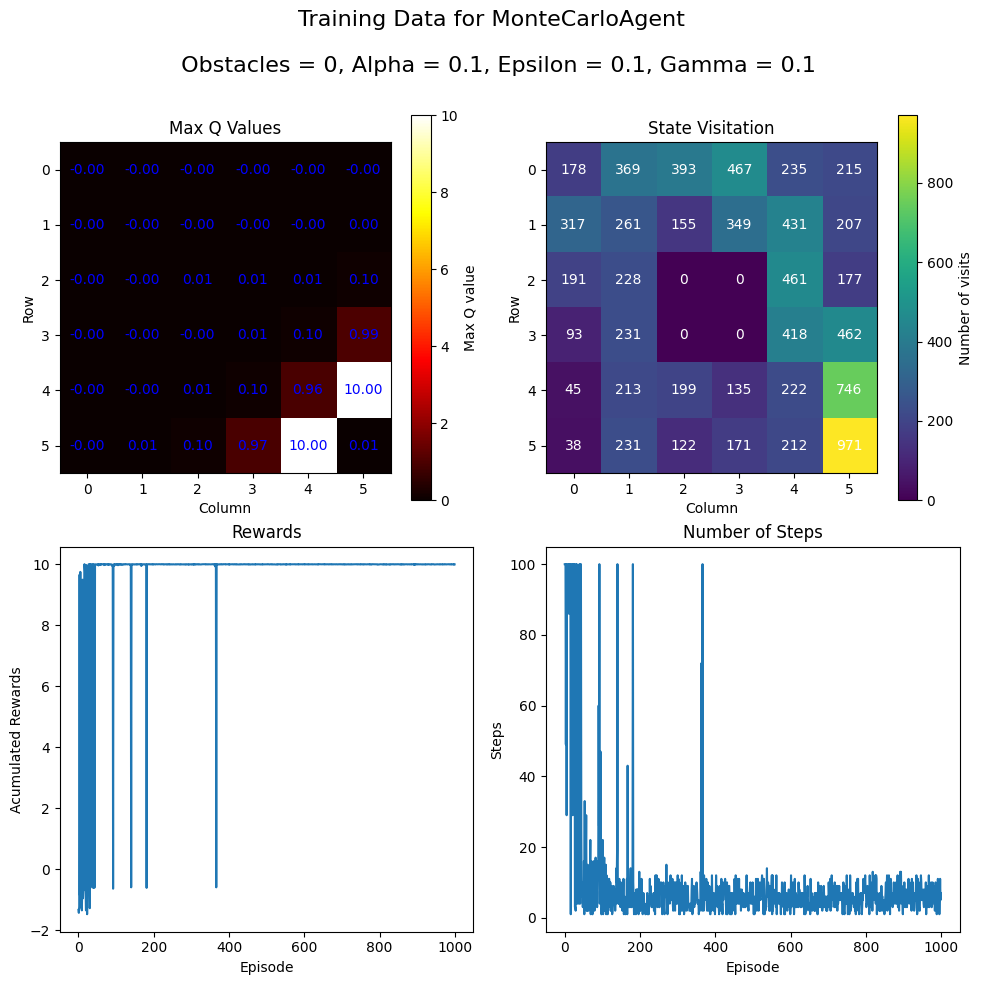

In [24]:
# Define the grid of parameters to test
param_grid = {
    'epsilon': [0.1, 0.5, 0.6],
    'gamma': [0.1, 0.6, 0.99],
    'alpha': [0.1, 0.5, 0.9]
}

# Number of obstacles to test
num_obstacles_list = [0, 2]

# Number of episodes to run for each experiment
episodes = 1000

# Number of maze to test
maze = 3

run_experiments(MonteCarloAgent, maze, episodes, num_obstacles_list, param_grid, save_plots=True, show_plots=False, render=False, max_steps=100)

In [25]:
def plot_sensitivity_analysis(parameter_values, performance_metrics, parameter_name, method, metric_name, title, show_plots, save_plots):
    """
    Plota um gráfico de sensibilidade para analisar o impacto de um parâmetro no desempenho do agente.

    Args:
    - parameter_values (list): Lista de valores do parâmetro.
    - performance_metrics (list): Lista de métricas de desempenho.
    - parameter_name (str): Nome do parâmetro.
    - method (str): Nome do método.
    - metric_name (str): Nome da métrica.
    - title (str): Título do gráfico.
    - show_plots (bool): Se True, exibe o gráfico.
    - save_plots (bool): Se True, salva o gráfico.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(parameter_values, performance_metrics, marker='o')
    plt.xlabel(parameter_name)
    plt.ylabel(metric_name)
    plt.title(title)
    plt.grid(True)

    if save_plots:
        plt.savefig(f'results/{method}/sensitivity_analysis_{parameter_name}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()

2.4.9) Tabelas de Desempenho:

Resumo das estatísticas de desempenho, como média e desvio padrão das recompensas, número de passos, e taxa de sucesso.

In [26]:
def create_performance_table(rewards, steps, success_count, total_episodes):
    """
    Cria uma tabela de desempenho com estatísticas de desempenho do agente.

    Args:
    - rewards (list): Lista das recompensas totais por episódio.
    - steps (list): Lista do número de passos por episódio.
    - success_count (int): Número total de episódios bem-sucedidos.
    - total_episodes (int): Número total de episódios.

    Returns:
    - pd.DataFrame: Tabela de desempenho.
    """
    data = {
        'Média das Recompensas': [pd.Series(rewards).mean()],
        'Desvio Padrão das Recompensas': [pd.Series(rewards).std()],
        'Média de Passos': [pd.Series(steps).mean()],
        'Desvio Padrão dos Passos': [pd.Series(steps).std()],
        'Taxa de Sucesso': [success_count / total_episodes]
    }

    performance_table = pd.DataFrame(data)
    return performance_table

2.4.10) Mapa de calor, curva de aprendizado e passos por epiódio.

In [27]:
def heatmap_learn_steps(rewards, steps, env, agent,  show_plots, save_plots, num_obstacles):
    fig = plt.figure(figsize=(20, 6))  # Largura, Altura
    fig.suptitle(f'Heatmap of Q Values, Learning Curve, and Number of Steps for {agent.__class__.__name__}', fontsize=16)

    q_values = np.zeros((env.num_rows, env.num_cols))
    for row in range(env.num_rows):
        for col in range(env.num_cols):
            state = (row, col)
            if state in agent.Q:
                # Pega o máximo valor Q para o estado
                q_values[row, col] = max(agent.Q[state].values())

    # Heatmap dos valores Q
    ax1 = fig.add_subplot(1, 3, 1)  # 1 linha, 3 colunas, posição 1
    im = ax1.imshow(q_values, cmap='hot', interpolation='nearest')
    fig.colorbar(im, ax=ax1, label='Q value')
    ax1.set_title(f'Heatmap of Q Values')

    # Curva de aprendizado
    ax2 = fig.add_subplot(1, 3, 2)  # 1 linha, 3 colunas, posição 2
    ax2.plot(rewards)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Reward')
    ax2.set_title('Learning Curve')

    # Número de passos
    ax3 = fig.add_subplot(1, 3, 3)  # 1 linha, 3 colunas, posição 3
    ax3.plot(steps)
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Steps')
    ax3.set_title('Number of Steps')

    # Ajusta o layout para que não haja sobreposição
    plt.tight_layout()

    if save_plots:
        plt.savefig(f'results/{agent.__class__.__name__}/heatmap_learn_steps_obs_{num_obstacles}_eps_{agent.epsilon}_gamma_{agent.gamma}_alpha_{agent.alpha}.png')

    if show_plots:
        plt.show()
    else:
        plt.close()

2.4.11) Resumo da tabela de performance:

In [28]:


def performance_summary(agent, num_obstacles, episodes, execution_time, metrics, performance_table):
    # Detalhes do Treinamento
    training_details = [
        ["Agent", agent.__class__.__name__],
        ["Obstacles", num_obstacles],
        ["Epsilon", agent.epsilon],
        ["Gamma", agent.gamma],
        ["Alpha", agent.alpha],
        ["Episodes", episodes],
        ["Execution Time (seconds)", f"{execution_time:.2f}"],
        ["Success Count", agent.success_count]
    ]

    # Métricas de Desempenho
    metrics_summary = []
    for metric, values in metrics.items():
        metrics_summary.append([f"Max {metric}", f"Episode {values.index(max(values))}", f"{metric} = {max(values)}"])
        metrics_summary.append([f"Min {metric}", f"Episode {values.index(min(values))}", f"{metric} = {min(values)}"])

    print(f"{agent.__class__.__name__} - {num_obstacles} Obstacles - {agent.epsilon} Epsilon - {agent.gamma} Gamma - {agent.alpha} Alpha\n")
    print("Training Details:")
    print(tabulate(training_details, headers=["Parameter", "Value"], tablefmt="pretty"))
    print("\nPerformance Metrics:")
    print(tabulate(metrics_summary, headers=["Metric", "Episode", "Value"], tablefmt="pretty"))
    print("\nPerformance Table:")
    print(tabulate(performance_table, headers="keys", tablefmt="pretty", showindex=False))
    print("\n")


2.4.12) Execução dos experimentos, tabelas e gráficos:

In [29]:
def run_experiments(agent_class, maze, episodes, num_obstacles_list, param_grid,  save_plots, show_plots, render=False, max_steps=100):
    results = {}
    # Nome do arquivo CSV para salvar os resultados
    csv_file = f'results/{agent_class.__name__}.csv'

    # Iterate over each combination of parameters
    for num_obstacles in num_obstacles_list:
        for epsilon in param_grid['epsilon']:
            for gamma in param_grid['gamma']:
                for alpha in param_grid['alpha']:
                    # Verifica se o arquivo já existe para decidir se precisa escrever o cabeçalho
                    file_exists = os.path.isfile(csv_file)
                    
                    # Inicializa o ambiente e o agente com as configurações dos parametros
                    env = MazeGameEnv(mazes[maze])
                    agent = agent_class(env, alpha=alpha, gamma=gamma, epsilon=epsilon)
                    
                    # Executa o treino
                    start_time = time.time()  
                    agent_data = agent.train(episodes, render=render, num_obstacles=num_obstacles, max_steps=max_steps)
                    end_time = time.time() 

                    execution_time = end_time - start_time

                    # Extrai e analiza os dados
                    rewards, steps = extract_data(agent_data)
                    metrics = {'reward': rewards, 'steps': steps}
                    
                    # Salva o resultado
                    results = {
                        'execution_time': execution_time,
                        'alpha': alpha,
                        'gamma': gamma,
                        'epsilon': epsilon,
                        'num_obstacles': num_obstacles,
                        'success_count': agent.success_count,
                        'failure_count': episodes - agent.success_count,
                        'rewards': [rewards],
                        'steps': [steps],
                        'visits': [agent.state_visits],
                    }
                    
                    # Criando a tabela de desempenho
                    performance_table = create_performance_table(rewards, steps, agent.success_count, episodes)
                    # Exemplo de chamada da função
                    performance_summary(agent, num_obstacles, episodes, execution_time, metrics, performance_table)


                    if show_plots or save_plots:
                        # Plot the heatmap, learning curve and number of steps
                        heatmap_learn_steps(rewards, steps, env, agent, show_plots, save_plots, num_obstacles)
                        
                        # Chama a função para plotar a curva de aprendizado
                        plot_learning_curve(rewards, agent, show_plots, save_plots, num_obstacles)

                        # Chama a função para plotar o gráfico do número de passos por episódio
                        plot_steps_per_episode(steps, agent, show_plots, save_plots, num_obstacles)

                        # # Chama a função para plotar o mapa de calor dos valores Q
                        plot_q_value_heatmap(agent, show_plots, save_plots, num_obstacles)

                        # Chama a função para plotar o mapa de calor de visitação dos estados
                        plot_state_visitation_heatmap(agent, env, show_plots, save_plots, num_obstacles)

                        # Chama a função para plotar o gráfico de barras
                        plot_success_vs_failures(episodes, agent, show_plots, save_plots, num_obstacles)

                        # Chama a função para plotar o gráfico de desempenho
                        plot_performance_over_episodes(rewards, steps, agent, show_plots, save_plots, num_obstacles)

                    # Execução da política ótima
                    if render:
                        agent.execute_optimal_policy(max_steps=100, start_pos=(0, 0))
                        agent.showQ()
                    
                    pd.DataFrame(results).to_csv(csv_file, mode='a', header=not file_exists, index=False)


##### 

##### Configurações utilizadas para os experimentos indepente da técnica utilizada.

**episódios** = 1000

**reward** = -1 quando mover sem obstáculos e -50 quando mover em paredes ou obstáculos -150 se passar de 100 movimentos no episódio

**alpha** = variável de acordo com a formula $\alpha_{t} = 1/N_(s_t, s_a)$

**gamma** = 0.1 , 0.6, 0.9, 0.99

**epsilon** =  de acordo com a formula $\epsilon_{t} = N0/(N0+N(st))$

**Ambiente** = Matriz 6 x 6 com obstáculo fixo ao centro  Labirinto número = 3

**Obstaculos** = 0 para deterministico e 2 para stochastico que irão aparecer de forma aleatória para cada episódio.



#### Técnica Monte Carlo

MonteCarloAgent - 0 Obstacles - 0.01 Epsilon - 0.1 Gamma - 0.1 Alpha

Training Details:
+--------------------------+-----------------+
|        Parameter         |      Value      |
+--------------------------+-----------------+
|          Agent           | MonteCarloAgent |
|        Obstacles         |        0        |
|         Epsilon          |      0.01       |
|          Gamma           |       0.1       |
|          Alpha           |       0.1       |
|         Episodes         |      1000       |
| Execution Time (seconds) |      0.59       |
|      Success Count       |       962       |
+--------------------------+-----------------+

Performance Metrics:
+------------+------------+------------------------------+
|   Metric   |  Episode   |            Value             |
+------------+------------+------------------------------+
| Max reward | Episode 28 |         reward = 10          |
| Min reward | Episode 20 | reward = -1.4010000000000007 |
| Max steps  | Episode 1  |    

FileNotFoundError: [Errno 2] No such file or directory: 'results/MonteCarloAgent/heatmap_learn_steps_obs_0_eps_0.01_gamma_0.1_alpha_0.1.png'

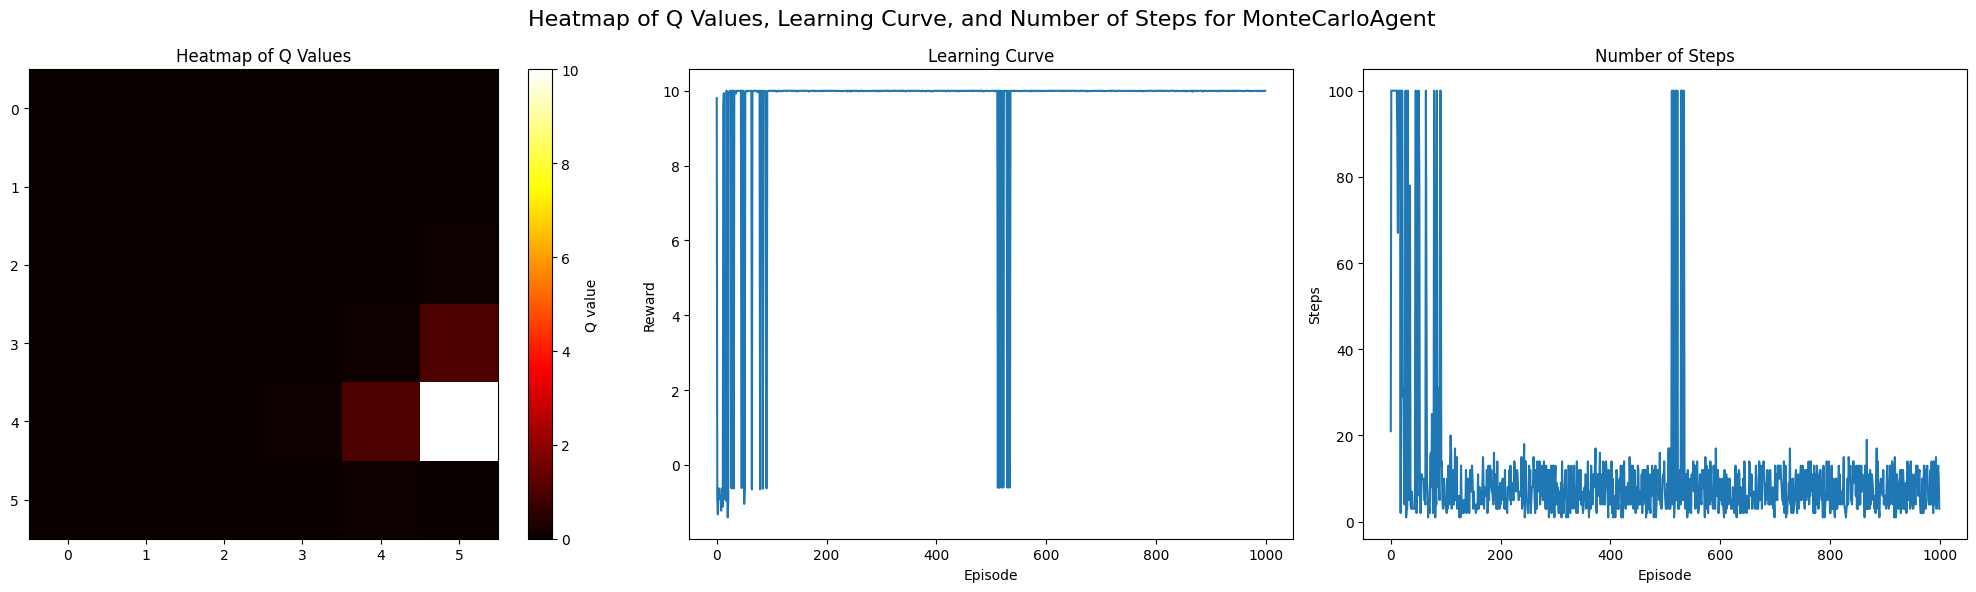

In [30]:
# Define the grid of parameters to test
param_grid = {
    'epsilon': [0.1, 0.5, 0.6],
    'gamma': [0.1, 0.6, 0.99],
    'alpha': [0.1, 0.5, 0.9]
}

# Number of obstacles to test
num_obstacles_list = [0, 2]

# Number of episodes to run for each experiment
episodes = 1000

# Number of maze to test
maze = 3

# Run the experiments
run_experiments(MonteCarloAgent, maze, episodes, num_obstacles_list, param_grid, save_plots=True, show_plots=False, render=False, max_steps=100)

# Open 0 CSV 
df = pd.read_csv(f'results/MonteCarloAgent.csv')
# Converte as strings de volta para arrays do NumPy
df['rewards'] = df['rewards'].apply(literal_eval)

# Pega o primeiro treinado para avaliar
rewards_deterministic = df[df['num_obstacles'] == 0]['rewards'].values[0]
rewards_stochastic = df[df['num_obstacles'] == 2]['rewards'].values[0]
plot_deterministic_vs_stochastic(rewards_deterministic, rewards_stochastic,method="MonteCarloAgent", show_plots=True, save_plots=False)

# Expande a coluna 'rewards', que contém listas, em várias linhas
df = df.explode('rewards')
# Converte os valores de 'rewards' para numéricos
df['rewards'] = pd.to_numeric(df['rewards'])
# Agrupa por 'alpha' e calcula a média das recompensas
grouped = df.groupby('alpha')['rewards'].mean()
# Prepara os dados para o gráfico
alpha_values = grouped.index.tolist()
average_rewards = grouped.values.tolist()
plot_sensitivity_analysis(alpha_values, average_rewards,parameter_name='alpha',metric_name='Recompensa Média',method="MonteCarloAgent",title='Análise de Sensibilidade para Alpha', show_plots=False, save_plots=False)

O gráfico acima é o resultado do processamento, esta imagem apresenta os valores das recompensas quando executado o código Monte Carlo neste tanto para o ambiente determinístico como para o ambiente estocástico.

O primeiro gráfico (deterministico), apresenta a convergência dos valores, que pode ser observada quando o gráfico fica restrito e comportado a uma faixa de valores, neste caso entre -200 e 0, como pode ser fácilmente observado no grafico do ambiente deterministico.

Já no segundo gráfico (estocástico), os valores das recompensas apresentam uma instabilidade por episódio de forma continua durante a execução em todos os 1000 episódios executados. Isso indica que o Bob pode ter sido impedido de continuar a sua jornada devido a uma barreira que impediu o seu retorno e que a execução parou pois atingiu o limite máximo programado de passos.

Outro ponto importante ao compararmos os 2 gráficos, é que durante a execução do método Monte Carlo em um ambiente estocástico, a presença de barreiras em posições diferentes em cada episódio, não retornou bons resultados neste estudo.

As tabelas abaixo irão apresentar o melhor resultado obtido com o uso da tecnica do Monte Carlo no ambiente determinístico proposto assim como a configuração utilizada para obter estes resultados.

O número de obstáculos = 0, indica que o ambiente é determinístico.

MonteCarloAgent - 0 Obstacles - 0.1 Epsilon - 0.6 Gamma - 0.5 Alpha

Training Details:

|        Parameter         |      Value      |
|--------------------------|-----------------|
|          Agent           | MonteCarloAgent |
|        Obstacles         |        0        |
|         Epsilon          |       0.1       |
|          Gamma           |       0.6       |
|          Alpha           |       0.5       |
|         Episodes         |      1000       |
| Execution Time (seconds) |      0.07       |
|      Success Count       |       988       |


Performance Metrics:

|   Metric   |  Episode   |     Value     |
|------------|------------|---------------|
| Max reward | Episode 6  | reward = 100  |
| Min reward | Episode 18 | reward = -960 |
| Max steps  | Episode 0  |  steps = 100  |
| Min steps  | Episode 6  |   steps = 1   |


Performance Table:

| Média das Recompensas | Desvio Padrão das Recompensas | Média de Passos | Desvio Padrão dos Passos | Taxa de Sucesso |
|-----------------------|-------------------------------|-----------------|--------------------------|-----------------|
|        83.744         |       78.85028745560685       |      8.136      |    11.385303207606249    |      0.988      |



Para avaliar estes dados devemos levar em consideração as seguintes informações: Média das Recompensas, Média de Passos e Taxa de Sucesso. 

A média das recompensas é uma composição de taxa de sucesso e o número de passos, a melhor média atingida é de 83.744.

O gráfio de curva de aprendizado (Learning Curve) abaixo, que tem como base a Média das Recompensas ao longo das épocas, este mapa deixa evidente a convergência que ocorre logo no inicio do gráfico, por volta do episódio 25.

O gráfico, mapa de temperatura abaixo (Heatmap of Q values), apresenta os pesos de cada posição, quanto mais escuro, menor o peso da tabela Q, ou seja, mais frio ou distante fica o bob do seu destino.

O último gráfico apresentado é o gráfico de número de passos abaixo (Number of Steps), apresenta uma redução do numero de passos ao longo do treinamento, com uma tendência a redução ao longo dos episódios (se observado da metade do gráfico para frente). O número de passos indica quantos passos o Bob terá que dar para chegar a sua casa, neste ponto é importante relembrar que existe uma trava limitando a rotina em 100 passos.  


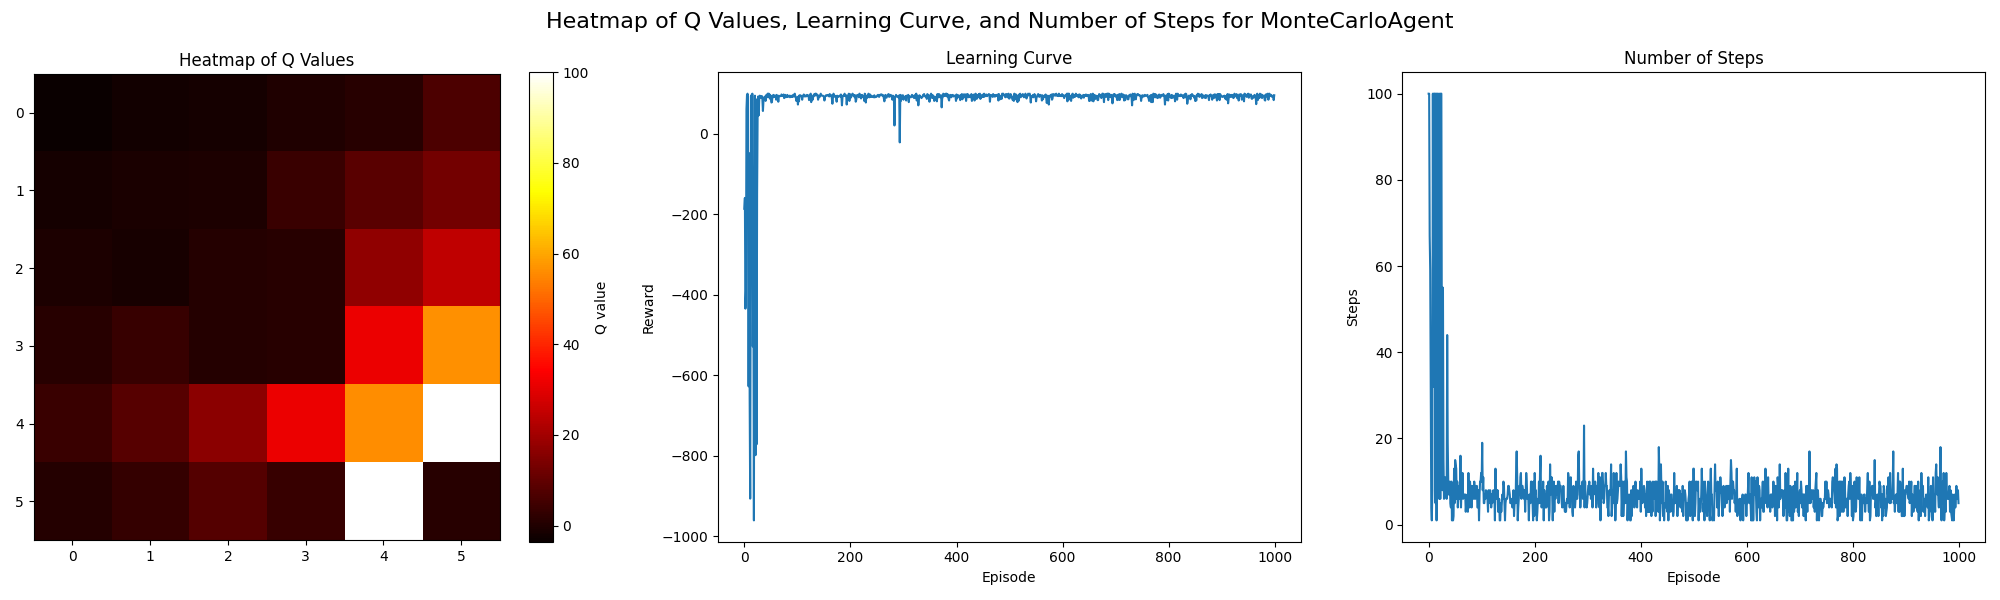

Durante a execução do Monte Carlo no modelo estocástico a configuração do Gamma apresentou uma grande alteração se comparada com a utilizada no modelo determinístico (gamma= 0.6), esta alteração faz muito sentido já que o Gamma determina os descontos utilizado para equilibrar a importancia das recompensas imediatas e futuras, ou seja, com o Gamma maior, as recompensas futuras vão ter mais valor que as recompensas imediatas. Portanto o ambiente estocástico do nosso ambiente vai previlegiar o um Gamma bem alto. como pode ser observado nas informações abaixo.

MonteCarloAgent - 2 Obstacles - 0.6 Epsilon - 0.99 Gamma - 0.1 Alpha

Training Details:

|        Parameter         |      Value      |
|--------------------------|-----------------|
|          Agent           | MonteCarloAgent |
|        Obstacles         |        2        |
|         Epsilon          |       0.6       |
|          Gamma           |      0.99       |
|          Alpha           |       0.1       |
|         Episodes         |      1000       |
| Execution Time (seconds) |      0.27       |
|      Success Count       |       914       |


Performance Metrics:

|   Metric   |   Episode   |     Value     |
|------------|-------------|---------------|
| Max reward | Episode 92  | reward = 100  |
| Min reward | Episode 960 | reward = -861 |
| Max steps  |  Episode 0  |  steps = 100  |
| Min steps  | Episode 92  |   steps = 1   |


Performance Table:

| Média das Recompensas | Desvio Padrão das Recompensas | Média de Passos | Desvio Padrão dos Passos | Taxa de Sucesso |
|-----------------------|-------------------------------|-----------------|--------------------------|-----------------|
|        -15.446        |       157.5129944716544       |      31.91      |    30.18972208085592     |      0.914      |


Para avaliar estes dados devemos levar em consideração as seguintes informações: Média das Recompensas, Média de Passos e Taxa de Sucesso. 

A média das recompensas é uma composição de taxa de sucesso e o número de passos, a melhor média atingida é de -15.446

Os gráficos abaixo apresentam o resultado do método Monte Carlo em um ambiente estocástico.
Iniciando pelo Gráfico da curva de aprendizado (Learning Curve), podemos observar que o gráfico possui uma instabilidade apresentando muitos picos, este resultado reflete a estocacidade do ambiente -- com os blocos que aparecem aleatórimente no ambiente para cada episódio; Um fator que certamente contribuiu com esta instabilidade foi o fato de que os blocos poderiam estar cercando o Bob impedindo assim a sua jornada e isso leva a uma redução na recompensa, este ponto de vista pode ser reforçado quando observamos o gráfico de número de passos ( Number of Steps) identificamos uma série de linhas que atingem o limite de passos liberado pelo sistema ao longo das épocas.
Já o Mapa de Calor da tabela Q (Heatmap of Q Values) apresenta pesos dos valores obtidos em cada posição (x,y) da tabela e a aplicação do reforço negativo aplicado aos pontos distantes do destino.

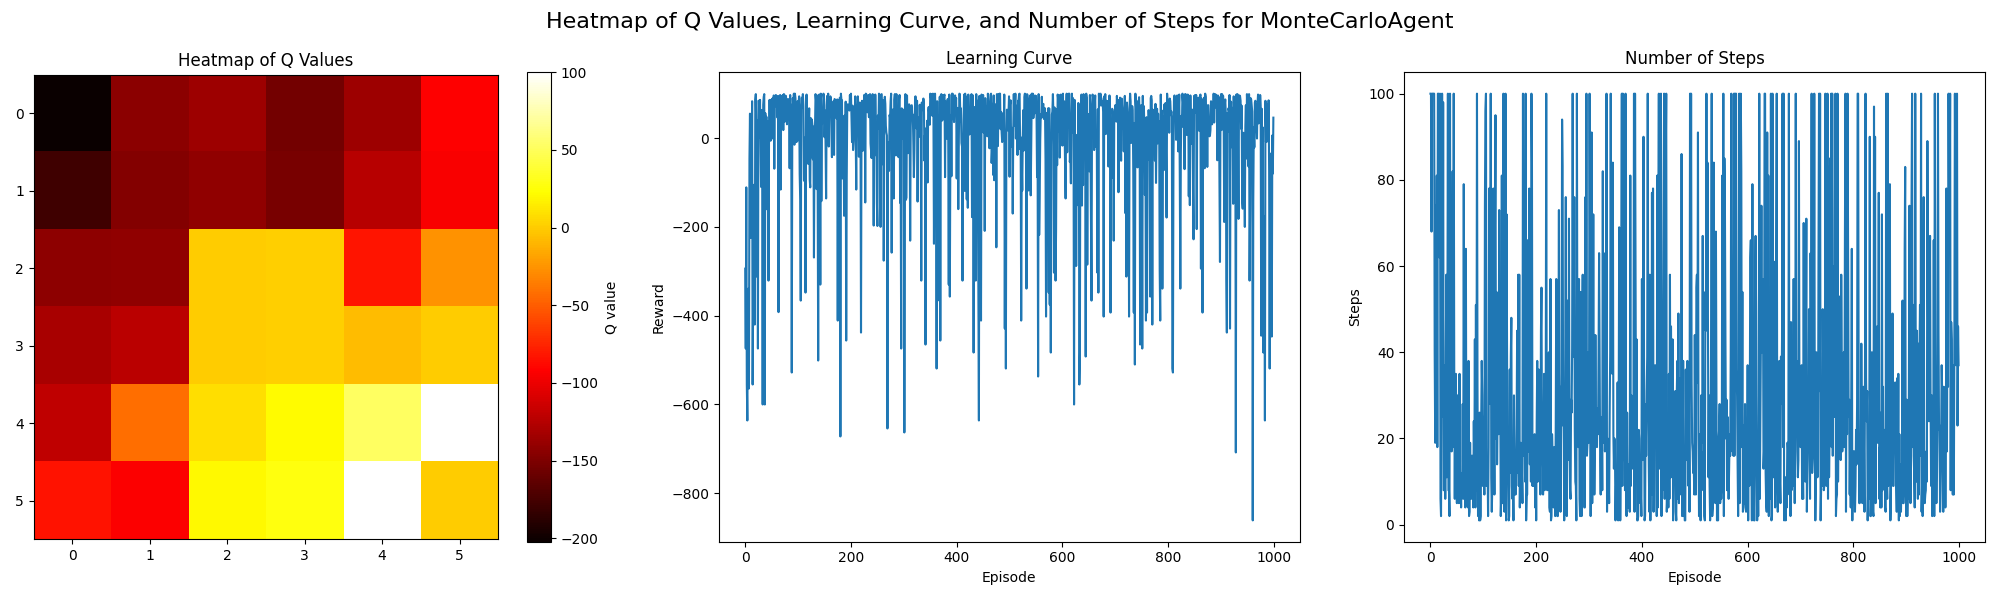

## Técnica Q-Learning

QLearningAgent - 0 Obstacles - 0.01 Epsilon - 0.1 Gamma - 0.1 Alpha

Training Details:
+--------------------------+----------------+
|        Parameter         |     Value      |
+--------------------------+----------------+
|          Agent           | QLearningAgent |
|        Obstacles         |       0        |
|         Epsilon          |      0.01      |
|          Gamma           |      0.1       |
|          Alpha           |      0.1       |
|         Episodes         |      1000      |
| Execution Time (seconds) |      1.64      |
|      Success Count       |      364       |
+--------------------------+----------------+

Performance Metrics:
+------------+------------+------------------+
|   Metric   |  Episode   |      Value       |
+------------+------------+------------------+
| Max reward | Episode 11 |   reward = 10    |
| Min reward | Episode 1  | reward = -10.352 |
| Max steps  | Episode 0  |   steps = 100    |
| Min steps  | Episode 11 |    steps = 1     |
+---------

FileNotFoundError: [Errno 2] No such file or directory: 'results/QLearningAgent/heatmap_learn_steps_obs_0_eps_0.01_gamma_0.1_alpha_0.1.png'

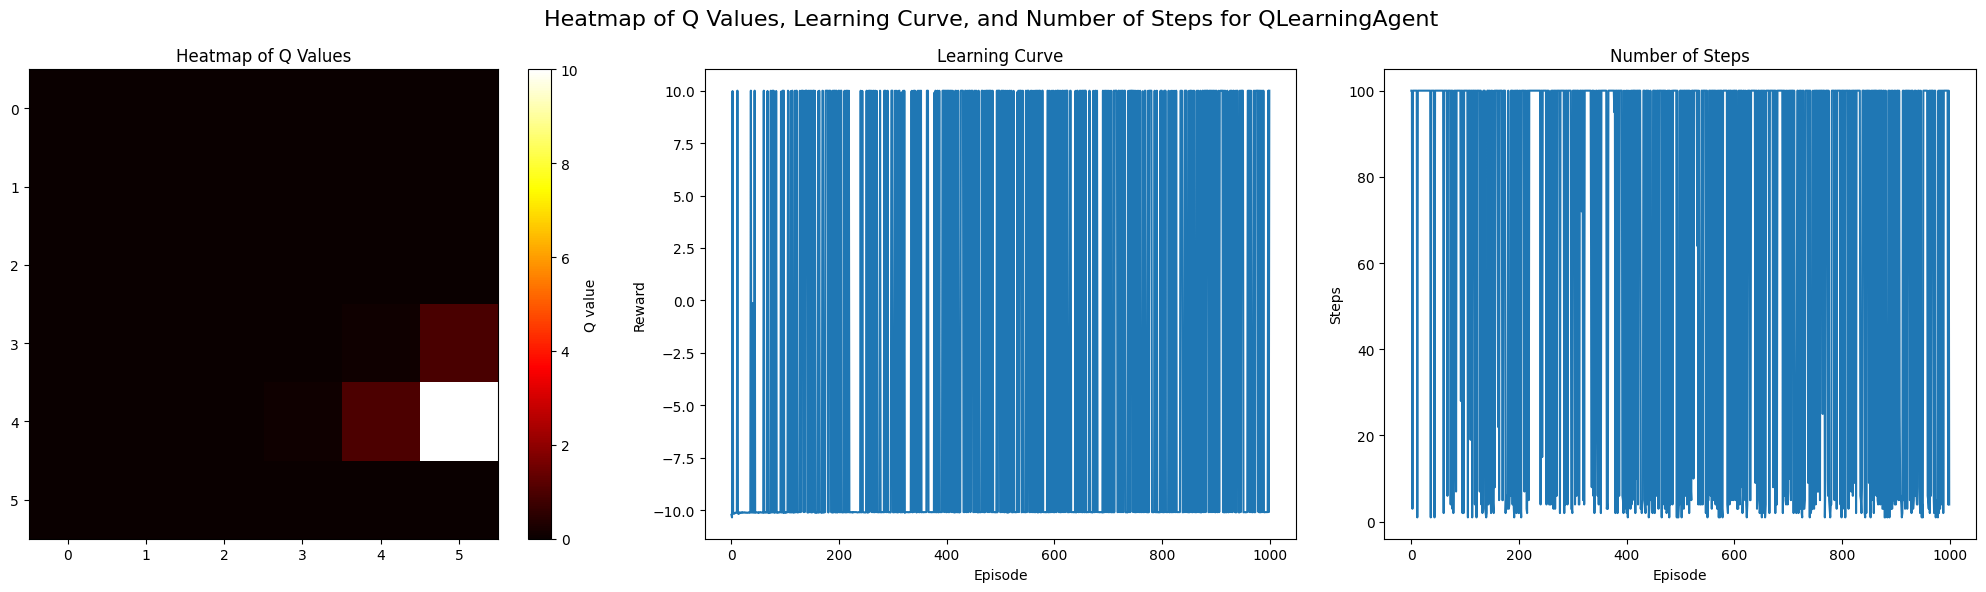

In [31]:
# # Define the grid of parameters to test
param_grid = {
    'epsilon': [0.1, 0.5, 0.6],
    'gamma': [0.1, 0.6, 0.99],
    'alpha': [0.1, 0.5, 0.9]
}

# Number of obstacles to test
num_obstacles_list = [0, 2]

# Number of episodes to run for each experiment
episodes = 1000

# Number of maze to test
maze = 3

# Run the experiments
run_experiments(QLearningAgent, maze, episodes, num_obstacles_list, param_grid, save_plots=True, show_plots=False, render=False, max_steps=100)

# Open the CSV file with the results
df = pd.read_csv(f'results/QLearningAgent.csv')
# Converte as strings de volta para arrays do NumPy
df['rewards'] = df['rewards'].apply(literal_eval)

# Pega o primeiro treinado para avaliar
rewards_deterministic = df[df['num_obstacles'] == 0]['rewards'].values[0]
rewards_stochastic = df[df['num_obstacles'] == 2]['rewards'].values[0]
plot_deterministic_vs_stochastic(rewards_deterministic, rewards_stochastic,method="QLearningAgent" ,show_plots=False, save_plots=False)

# Expande a coluna 'rewards', que contém listas, em várias linhas
df = df.explode('rewards')
# Converte os valores de 'rewards' para numéricos
df['rewards'] = pd.to_numeric(df['rewards'])
# Agrupa por 'alpha' e calcula a média das recompensas
grouped = df.groupby('alpha')['rewards'].mean()
# Prepara os dados para o gráfico
alpha_values = grouped.index.tolist()
average_rewards = grouped.values.tolist()
plot_sensitivity_analysis(alpha_values, average_rewards,parameter_name='alpha',metric_name='Recompensa Média',method="QLearningAgent",title='Análise de Sensibilidade para Alpha', show_plots=False, save_plots=False)


As tabelas abaixo apresentam os resultados obtidos pela execução do Q-Learning no ambiente determinístico (0 Obstacles - obstáculos).
É fácil observar que a maior parte dos episódios apresentam resultados promissores na coluna taxa de sucesso.

QLearningAgent - 0 Obstacles - 0.01 Epsilon - 0.6 Gamma - 0.5 Alpha

Training Details:

|        Parameter         |     Value      |
|--------------------------|----------------|
|          Agent           | QLearningAgent |
|        Obstacles         |       0        |
|         Epsilon          |      0.01      |
|          Gamma           |      0.6       |
|          Alpha           |      0.5       |
|         Episodes         |      1000      |
| Execution Time (seconds) |      0.05      |
|      Success Count       |      1000      |


Performance Metrics:

|   Metric   |  Episode  |    Value     |
|------------|-----------|--------------|
| Max reward | Episode 2 | reward = 100 |
| Min reward | Episode 0 | reward = -92 |
| Max steps  | Episode 0 |  steps = 76  |
| Min steps  | Episode 2 |  steps = 1   |


Performance Table:

| Média das Recompensas | Desvio Padrão das Recompensas | Média de Passos | Desvio Padrão dos Passos | Taxa de Sucesso |
|-----------------------|-------------------------------|-----------------|--------------------------|-----------------|
|        94.948         |       8.418560932140846       |      5.521      |    4.399649521941027     |       1.0       |

Para avaliar estes dados devemos levar em consideração as seguintes informações: Média das Recompensas, Média de Passos e Taxa de Sucesso. 

A média das recompensas é uma composição de taxa de sucesso e o número de passos, a melhor média atingida é de 94.948

Os gráficos abaixo apresentam os resultados obtidos pelo treinamento Q-Learning, como pode ser observado, o Gráfico da Curva de Recompensa (Learning Curve) tem uma convergência a partir do episódio 500 mantendo um range de recompensa bem estreito a partir deste ponto. No gráfico de Número de Passos (Number of Steps) podemos identificar a queda do número de passos relacionada com os episódios de treinamento, esse gráfico corrobora com o gráfico de curva de aprendizado que se sintetizarmos os dois gráficos, é possível traçar uma relação de: quanto mais aprende, menor será o número de passos.

Já o gráfico de mapa de calor (Heatmap of Q Values) identifica os menores valores com a colocação escura, o que obriga o Bob sair da área escura para área clara, buscando obter uma maior pontuação.

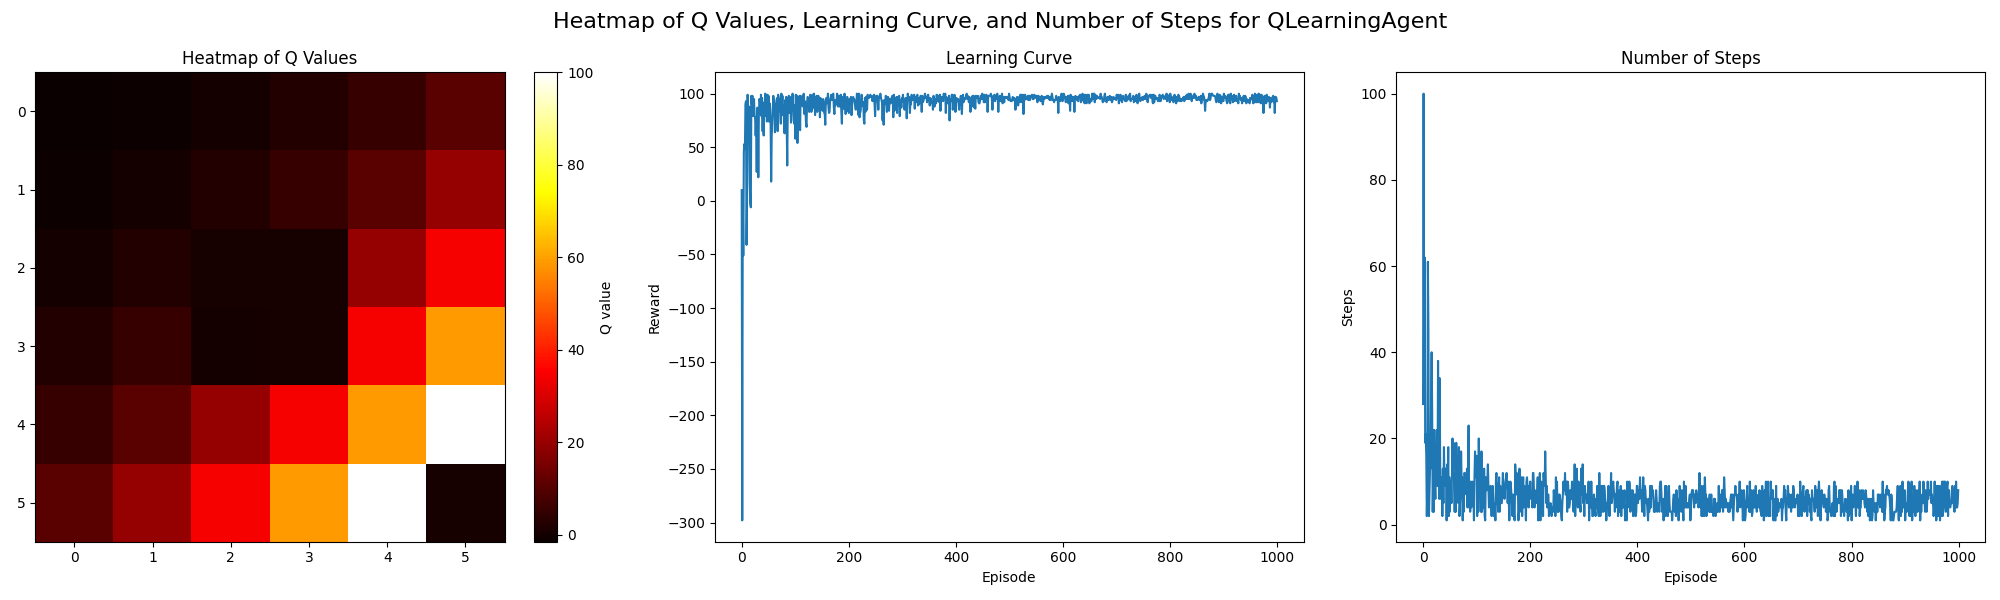

Para o ambiente estocástico, o Qlearning também apresenta uma certa queda na taxa de sucesso , como ocorreu com este ambiente no Monte Carlo.

O melhor resultado obtido durante está execução foi para a configuração apresentada abaixo e o Gamma também foi um fator inportante para o aumento da taxa de sucesso.

QLearningAgent - 2 Obstacles - 0.01 Epsilon - 0.99 Gamma - 0.5 Alpha

Training Details:

|        Parameter         |     Value      |
|--------------------------|----------------|
|          Agent           | QLearningAgent |
|        Obstacles         |       2        |
|         Epsilon          |      0.01      |
|          Gamma           |      0.99      |
|          Alpha           |      0.5       |
|         Episodes         |      1000      |
| Execution Time (seconds) |      0.15      |
|      Success Count       |      918       |


Performance Metrics:

|   Metric   |  Episode   |     Value     |
|------------|------------|---------------|
| Max reward | Episode 64 | reward = 100  |
| Min reward | Episode 45 | reward = -379 |
| Max steps  | Episode 0  |  steps = 100  |
| Min steps  | Episode 64 |   steps = 1   |


Performance Table:

| Média das Recompensas | Desvio Padrão das Recompensas | Média de Passos | Desvio Padrão dos Passos | Taxa de Sucesso |
|-----------------------|-------------------------------|-----------------|--------------------------|-----------------|
|        49.889         |       86.22340258975028       |     22.057      |     29.9730234232907     |      0.918      |

Para avaliar estes dados devemos levar em consideração as seguintes informações: Média das Recompensas, Média de Passos e Taxa de Sucesso. 

A média das recompensas é uma composição de taxa de sucesso e o número de passos, a melhor média atingida é de 49.889.

Os gráficos abaixo apresentam uma estrutura semelhante com a obtida no ambiente estocástico do método Monte Carlo, ou seja um mapa de Curva de Aprendizado (Learning Curve) e Número de Passos (Number of Steps) bem aleatório.

O Gráfico de mapa de calor (Heatmap of Q Values) também apresenta algumas distorções como por exemplo a posição (1,1) que monta uma ilha com um valor alto cercado de áreas de valores baixos.

Estas distorções são fruto do ambiente estocástico provadas pelos blocos (paredes) inseridos de forma aleatória no treinamento dos episódios. A mesma situação que ocorreu no metodo estocástico do Monte Carlo de travar o movimento do Bob durante sua movimentação.

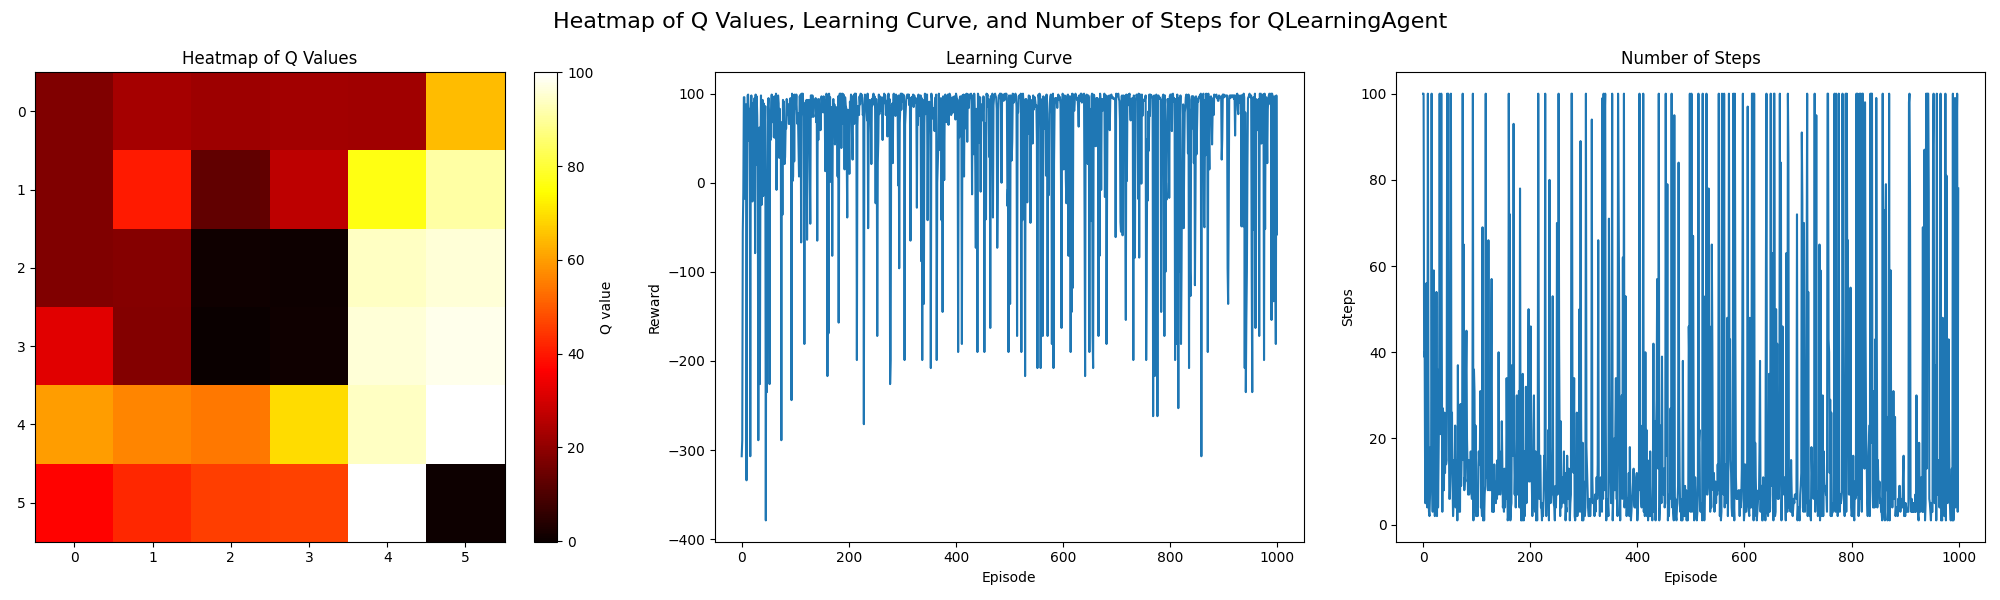

## Técnica SARSA

In [ ]:
# # Define the grid of parameters to test
param_grid = {
    'epsilon': [0.1, 0.5, 0.6],
    'gamma': [0.1, 0.6, 0.99],
    'alpha': [0.1, 0.5, 0.9]
}

# Number of obstacles to test
num_obstacles_list = [0, 2]

# Number of episodes to run for each experiment
episodes = 1000

# Number of maze to test
maze = 3

# Run the experiments
run_experiments(SARSAgent, maze, episodes, num_obstacles_list, param_grid, save_plots=True, show_plots=False, render=False, max_steps=100)

# Open the CSV file with the results
df = pd.read_csv(f'results/SARSAgent.csv')
# Converte as strings de volta para arrays do NumPy
df['rewards'] = df['rewards'].apply(literal_eval)

# Pega o primeiro treinado para avaliar
rewards_deterministic = df[df['num_obstacles'] == 0]['rewards'].values[0]
rewards_stochastic = df[df['num_obstacles'] == 2]['rewards'].values[0]
plot_deterministic_vs_stochastic(rewards_deterministic, rewards_stochastic,method="SARSAgent" ,show_plots=False, save_plots=False)

# Expande a coluna 'rewards', que contém listas, em várias linhas
df = df.explode('rewards')
# Converte os valores de 'rewards' para numéricos
df['rewards'] = pd.to_numeric(df['rewards'])
# Agrupa por 'alpha' e calcula a média das recompensas
grouped = df.groupby('alpha')['rewards'].mean()
# Prepara os dados para o gráfico
alpha_values = grouped.index.tolist()
average_rewards = grouped.values.tolist()
plot_sensitivity_analysis(alpha_values, average_rewards,parameter_name='alpha',metric_name='Recompensa Média',method="SARSAgent",title='Análise de Sensibilidade para Alpha', show_plots=False, save_plots=False)

SARSAgent - 0 Obstacles - 0.01 Epsilon - 0.1 Gamma - 0.1 Alpha

Training Details:
+--------------------------+-----------+
|        Parameter         |   Value   |
+--------------------------+-----------+
|          Agent           | SARSAgent |
|        Obstacles         |     0     |
|         Epsilon          |   0.01    |
|          Gamma           |    0.1    |
|          Alpha           |    0.1    |
|         Episodes         |   1000    |
| Execution Time (seconds) |   0.82    |
|      Success Count       |    996    |
+--------------------------+-----------+

Performance Metrics:
+------------+------------+---------------+
|   Metric   |  Episode   |     Value     |
+------------+------------+---------------+
| Max reward | Episode 29 | reward = 100  |
| Min reward | Episode 3  | reward = -154 |
| Max steps  | Episode 3  |  steps = 100  |
| Min steps  | Episode 29 |   steps = 1   |
+------------+------------+---------------+

Performance Table:
+-----------------------+-------

As tabelas abaixo apresentam os valores obtidos em um dos melhores episódios do método SARSA quando executado em um ambiente determinístico.

O metodo SARSA assim como o Q-Learning apresentaram bons resultados para o metodo determinístico.

SARSAgent - 0 Obstacles - 0.01 Epsilon - 0.6 Gamma - 0.5 Alpha

Training Details:

|        Parameter         |   Value   |
|--------------------------|-----------|
|          Agent           | SARSAgent |
|        Obstacles         |     0     |
|         Epsilon          |   0.01    |
|          Gamma           |    0.6    |
|          Alpha           |    0.5    |
|         Episodes         |   1000    |
| Execution Time (seconds) |   0.54    |
|      Success Count       |    999    |


Performance Metrics:

|   Metric   |  Episode   |     Value     |
|------------|------------|---------------|
| Max reward | Episode 24 | reward = 100  |
| Min reward | Episode 4  | reward = -208 |
| Max steps  | Episode 4  |  steps = 100  |
| Min steps  | Episode 24 |   steps = 1   |


Performance Table:

| Média das Recompensas | Desvio Padrão das Recompensas | Média de Passos | Desvio Padrão dos Passos | Taxa de Sucesso |
|-----------------------|-------------------------------|-----------------|--------------------------|-----------------|
|        93.969         |      12.879437833963054       |      6.138      |    4.5731684716255385    |      0.999      |

Para avaliar estes dados devemos levar em consideração as seguintes informações: Média das Recompensas, Média de Passos e Taxa de Sucesso. 

A média das recompensas é uma composição de taxa de sucesso e o número de passos, a melhor média atingida é de 93.969.

O gráfico da Curva de Aprendizado (Learning Curve), apresentado abaixo, se apresenta bem menos comportado que os método utilizados anteriormente a não é possível encontrar uma curva de convergência para este método devido a grandes desvios ocorridos ao longo das épocas. O mesmo desvio ocorre para o Número de Passos (Number of Steps).

O gráfico de Mapa de Calor (Heatmap of Q Value) apresenta valores baixo apenas no lado oposto ao destino, mas a distribuição dos valores se apresentam um aumento dos valores com sentido ao destino, o que indica claro direcionamento do Bob para o seu destino.

![heatmap_learn_steps_obs_0_eps_0.01_gamma_0.6_alpha_0.5 copy.png](<attachment:heatmap_learn_steps_obs_0_eps_0.01_gamma_0.6_alpha_0.5 copy.png>)
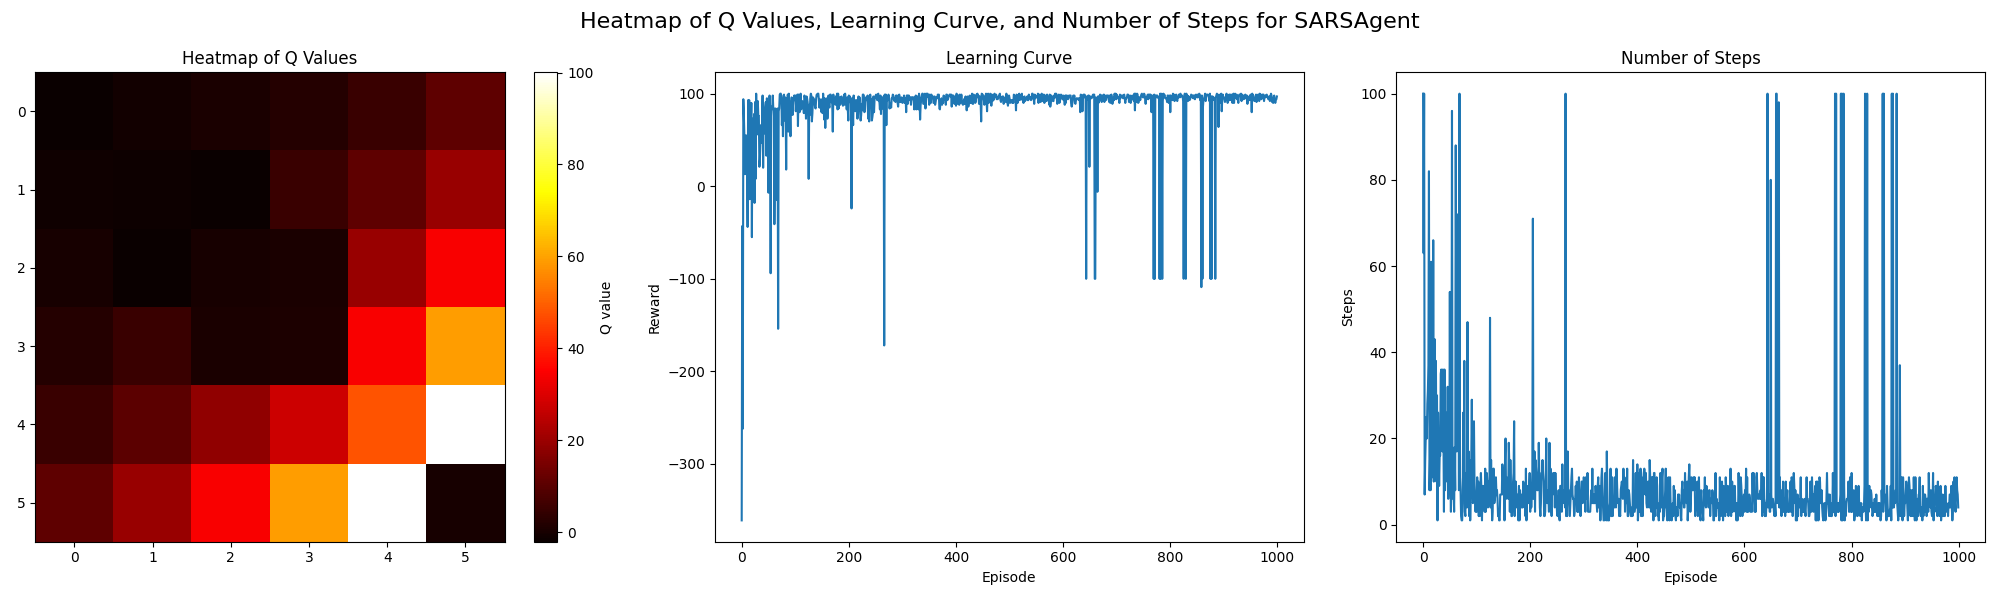

As tabelas abaixo apresentam os valores obtidos em um dos melhores episódios do método SARSA quando executado em um ambiente estocástico.

SARSAgent - 2 Obstacles - 0.01 Epsilon - 0.99 Gamma - 0.5 Alpha

Training Details:

|        Parameter         |   Value   |
|--------------------------|-----------|
|          Agent           | SARSAgent |
|        Obstacles         |     2     |
|         Epsilon          |   0.01    |
|          Gamma           |   0.99    |
|          Alpha           |    0.5    |
|         Episodes         |   1000    |
| Execution Time (seconds) |   2.24    |
|      Success Count       |    882    |


Performance Metrics:

|   Metric   |  Episode   |     Value     |
|------------|------------|---------------|
| Max reward | Episode 30 | reward = 100  |
| Min reward | Episode 42 | reward = -370 |
| Max steps  | Episode 4  |  steps = 100  |
| Min steps  | Episode 30 |   steps = 1   |


Performance Table:

| Média das Recompensas | Desvio Padrão das Recompensas | Média de Passos | Desvio Padrão dos Passos | Taxa de Sucesso |
|-----------------------|-------------------------------|-----------------|--------------------------|-----------------|
|         31.43         |      105.38088171120145       |     26.332      |    33.29841678759758     |      0.882      |


Para avaliar estes dados devemos levar em consideração as seguintes informações: Média das Recompensas, Média de Passos e Taxa de Sucesso. 

A média das recompensas é uma composição de taxa de sucesso e o número de passos, a melhor média atingida é de 31.43.

O gráfico de curva de aprendizado (Learning Curve ) abaixo, demonstra que o SARSA também não convergiu quando o ambiente passou a ser estocástico, o mesmo problema ocorreu com o número de passos que foi limitado pela trava de 100 passos, isso é claro quando é observada na tabela de Número de Passos (Number of Steps) o limite superior do gráfico sendo atingido diversas vezes durante o treinamento das épocas.
O Mapa de Calor (Heatmap od Q Values) apresenta um leve direcionamento do Bob mas possui algumas zonas isoladas por exemplo : Posição (4,0).     

![heatmap_learn_steps_obs_2_eps_0.01_gamma_0.99_alpha_0.5 copy.png](<attachment:heatmap_learn_steps_obs_2_eps_0.01_gamma_0.99_alpha_0.5 copy.png>)
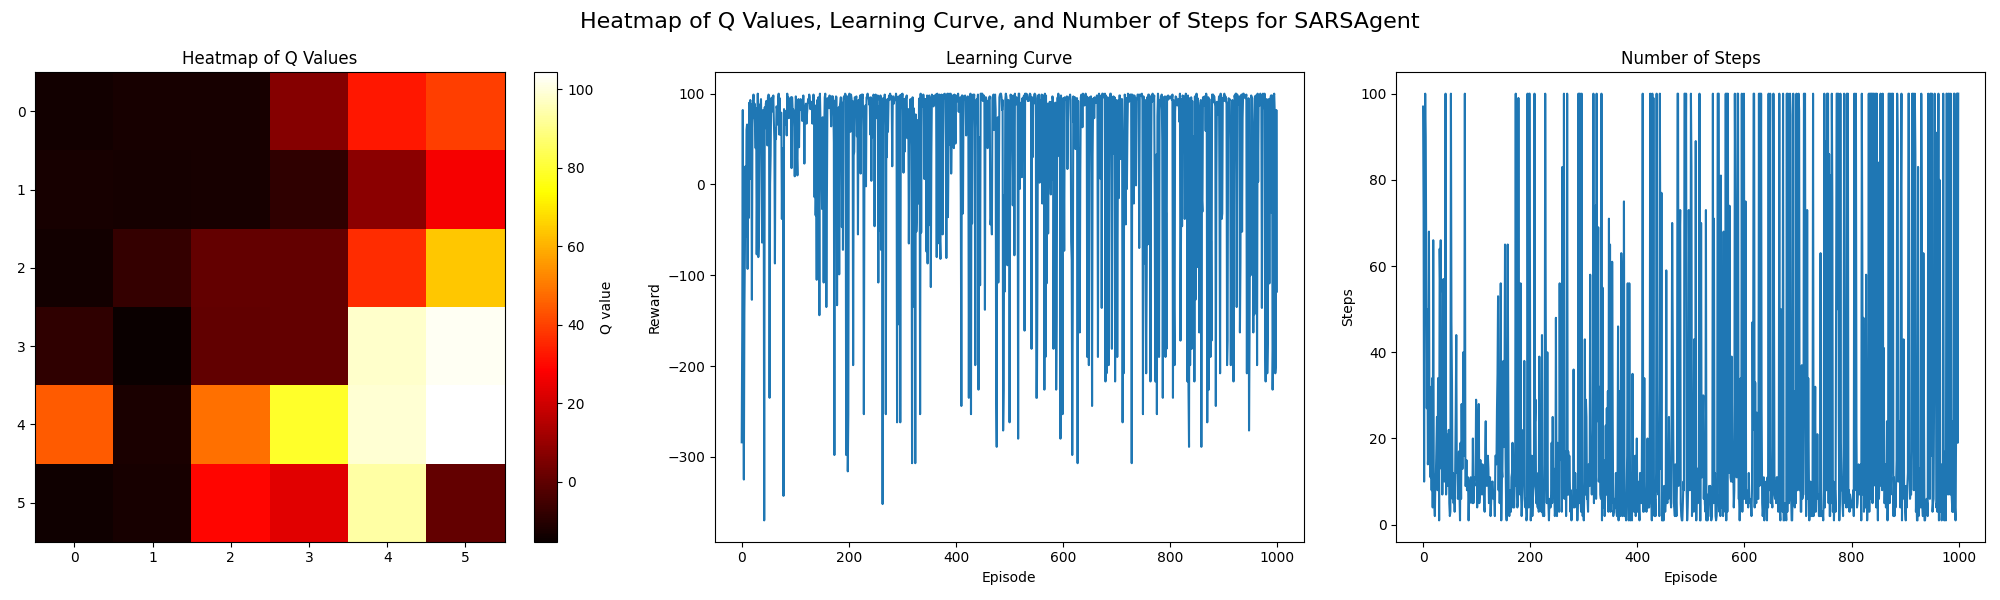

## Comparação entre os algoritmos

In [ ]:
# Open the CSV file with the results
df_MonteCarloAgent = pd.read_csv(f'results/MonteCarloAgent.csv')
df_QLearningAgent = pd.read_csv(f'results/QLearningAgent.csv')
df_SARSAAgent = pd.read_csv(f'results/SARSAgent.csv')

### Comparação do Tempo de Execução

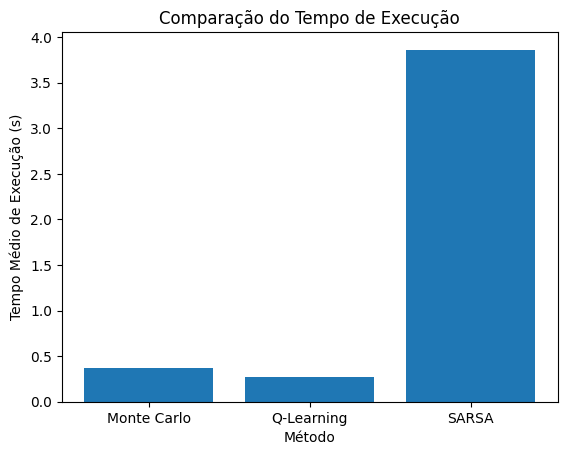

In [ ]:
times = [df_MonteCarloAgent['execution_time'].mean(), df_QLearningAgent['execution_time'].mean(), df_SARSAAgent['execution_time'].mean()]
methods = ['Monte Carlo', 'Q-Learning', 'SARSA']

plt.bar(methods, times)
plt.xlabel('Método')
plt.ylabel('Tempo Médio de Execução (s)')
plt.title('Comparação do Tempo de Execução')
plt.show()

O Gráfico de comparação do Tempo de Execução, apresenta a média do tempo computacional dos episódios levando em conta cada método utilizado. Para este projeto de pesquisa o método que menos consumiu tempo de máquina foi o Q-Learning, seguido do Monte Carlo e por último o SARSA com uma ampla diferença para a segunda posição como pode ser observado no gráfico. 
É importante informar que este gráfico apresentado pega apenas o período do treino dos métodos propostos.

### Comparação da Taxa de Sucesso

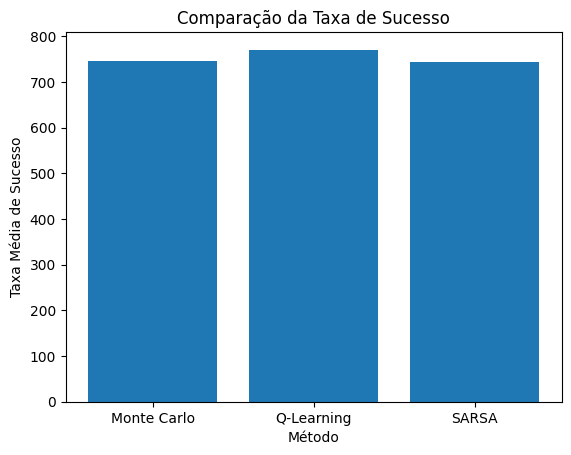

In [ ]:
success_rates = [df_MonteCarloAgent['success_count'].mean(), df_QLearningAgent['success_count'].mean(), df_SARSAAgent['success_count'].mean()]

plt.bar(methods, success_rates)
plt.xlabel('Método')
plt.ylabel('Taxa Média de Sucesso')
plt.title('Comparação da Taxa de Sucesso')
plt.show()


O gráfico de Comparação da Taxa de Sucesso, captura os valores de sucesso de cada método proposto. Levando em consideração esta taxa, a diferença de sucesso entre os métodos utilizados estão muito próximas umas das outras, porém o gráfico não separa a taxa de sucesso por ambiente (determinístico do estocástico) o que pode gerar um erro na escolha do método devido a uma possível distorção gerada por esta análise conjunta.   

# Conclusão

## Melhores Conjuntos de Parâmetros
Identifica e exibe os melhores conjuntos de parâmetros para cada método baseado em critérios como recompensa total ou taxa de sucesso, todos apresentados uma uma forma bruta, entretanto esta forma de apresentação tambémapresenta a mesma falha do gráfico Comparação da Taxa de Sucesso, pois ele não separa os ambiente (determinístico do estocástico)

In [ ]:
# Exemplo: identifica o conjunto de parâmetros com a maior taxa de sucesso para cada método
best_params_monte_carlo = df_MonteCarloAgent.loc[df_MonteCarloAgent['success_count'].idxmax()]
best_params_q_learning = df_QLearningAgent.loc[df_QLearningAgent['success_count'].idxmax()]
best_params_sarsa = df_SARSAAgent.loc[df_SARSAAgent['success_count'].idxmax()]

# Imprime os melhores conjuntos de parâmetros
print("Melhores Parâmetros Monte Carlo:\n", best_params_monte_carlo)
print("Melhores Parâmetros Q-Learning:\n", best_params_q_learning)
print("Melhores Parâmetros SARSA:\n", best_params_sarsa)


Melhores Parâmetros Monte Carlo:
 execution_time                                             0.159519
alpha                                                           0.5
gamma                                                          0.99
epsilon                                                         0.5
num_obstacles                                                     0
success_count                                                   998
failure_count                                                     2
rewards           [-456, -165, -339, -86, -87, 81, 88, -83, -317...
steps             [100, 77, 100, 34, 80, 11, 4, 49, 94, 13, 26, ...
visits            {(0, 0): 209, (0, 1): 206, (0, 2): 192, (0, 3)...
Name: 16, dtype: object
Melhores Parâmetros Q-Learning:
 execution_time                                             0.067357
alpha                                                           0.9
gamma                                                           0.6
epsilon                  

## Código e Parametros utilizado

O sistema desenvolvido para a atividade proposta, gera diversos gráficos localizados no diretório results, raiz do sistema onde possui 3 subdiretórios, já apresentados no tópico: entrada de dados.
Estes diretórios são responsáveis por armazenar os gráficos de cada método na sua respectiva pasta. Para que sejam gerados o método escolhido deve ter a opção : save_plots=True.



## Resultados

Os resultados colhidos ao longo desta atividade se mostraram promissores para 2 métodos:  Monte Carlo e Q-Learning; Ambos os métodos estudados apresentaram bons resultados finais, alguns despendendo mais tempo de máquina que outros, mas no geral os resultados não foram tão discretpantes como o apresetado pelo metodo SARSA que não convergiu.

A tabela abaixo apresenta uma visão geral dos melhores resultados obtidos durantes o estudo destes métodos.

Tabela de Resultados:

|           Método             |  Pontuação (de 1000)  |  Num. Passos  |
|------------------------------|-----------------------|---------------|
| Q-Learning * (determinístico)|         1000          |     5.521     |
| Q-Learning * (estocástico)   |          918          |    22.057     |
| Monte Carlo  (determinístico)|          988          |     8.136     |
| Monte Carlo  (estocástico)   |          914          |    31.910     |
| SARSA        (determinístico)|          999          |     6.138     |
| SARSA        (estocástico)   |          882          |    26.332     |


Nesta atividade os fatores de importância são: Pontuação (número de acertos) e o número de passos.

## Resposta 4

Quando observamos a tabela de resultados acima, fica simples entender paraq isso vamos escolher o ambiente Q-Learning determinístico. Este método ele teve a pontuação 1000 de 1000 execuções, ou seja 100% das vezes o Bob chegou ao seu destino e teve a menor média de número de passos em 1000 tentativas, que significa que ele foi eficiente e andou pouco para chegar ao seu destino. 

Numero de passos para chegar ao destino é: 
    
    Num. Passos / Pontuação = Ds

    5.521 / 1000 = 5,521 

A mesma regra se aplica para os outros itens.

Desta forma, fica simples compreender a vantagem em se usar o método Q-Learning para este este projeto, em qualquer um dos ambientes,  estocástico ou determinístico, o Q-Learning supera os outros métodos. 

## Resposta 2

A função de recompensa foi de grande ajuda para que fosse identificado o melhor resultado dentro das épocas, mesmo para este estudo proposto que possui apenas 2 itens na política (acertos e número de passos), escolher apenas 1 como referência, pode não extrair o melhor resultado obtido. por exemplo: 2 épocas valores de pontuação próximo e número de passos diferentes como apresetado na tabela abaixo

|epoca | pontuação | passos|
|------|-----------|-------|
|  X   |    900    |   70  |
|  Y   |    950    |  150  |

Usando apenas uma variável certamente a pontuação seria escolhida deixando de lado o peso do número de passos. E ponderar estas variáveis é a vantagem de se utilizar esta recompensa.
Sendo assim, para este projeto a política de recompensa foi implementada e utilizada para extração dos dados de maior importância para apresentação deste relatório.

## Resposta 1
Se aplicassemos o na solução proposta possivelmente teriamos:
Vantagens: 
    1-) Uma maior estabilidade nas estimativas calculadas, ainda mais se considerarmos que o conjunto de dados utilizado para esta atividade é pequeno.
    2-) Retirar a sensibilidade de outliers.
    3-) Produz intervalos de dados confiáveis o que permite estimar a variabilidade do modelo.
Desvantagens:
    1-) Custo computacional.
    2-) Aumento da complexidade do código.


 ## Resposta 3

 Possíveis melhorias
 Entre as melhorias que poderiam ser implementadas no sistema a mais interessante seria eliminar das épocas as situações estocásticas que levem a algum impedimento do Bob chegar ao seu destino como por exemplo: paredes travando totalmente a circulação do Bob.

# Testes

In [ ]:
maze = 3
alpha = 0.9
gamma = 0.9
epsilon = 0.99
episodes = 1000
render = True
num_obstacles = 0
max_steps = 100
num_obstacles_list = [0,2]
param_grid = {
    'epsilon': [epsilon],
    'gamma': [gamma],
    'alpha': [alpha]
}
func = False
env = MazeGameEnv(mazes[maze])
agent = MonteCarloAgent(env, alpha=alpha, gamma=gamma, epsilon = epsilon, use_linear_approximation = func)
agent.train(episodes, render=render, num_obstacles=num_obstacles, max_steps=max_steps)
agent.execute_optimal_policy(max_steps=100, start_pos=(0, 0))
                    

SARSAgent - 0 Obstacles - 0.99 Epsilon - 0.9 Gamma - 0.9 Alpha

Training Details:
+--------------------------+-----------+
|        Parameter         |   Value   |
+--------------------------+-----------+
|          Agent           | SARSAgent |
|       Approximator       |   False   |
|        Obstacles         |     0     |
|         Epsilon          |   0.99    |
|          Gamma           |    0.9    |
|          Alpha           |    0.9    |
|         Episodes         |   1000    |
| Execution Time (seconds) |   12.11   |
|      Success Count       |    996    |
+--------------------------+-----------+

Performance Metrics:
+------------+------------+------------------------------+
|   Metric   |  Episode   |            Value             |
+------------+------------+------------------------------+
| Max reward | Episode 24 |         reward = 10          |
| Min reward | Episode 0  | reward = -1.2220000000000004 |
| Max steps  | Episode 0  |         steps = 200          |
| Min ste

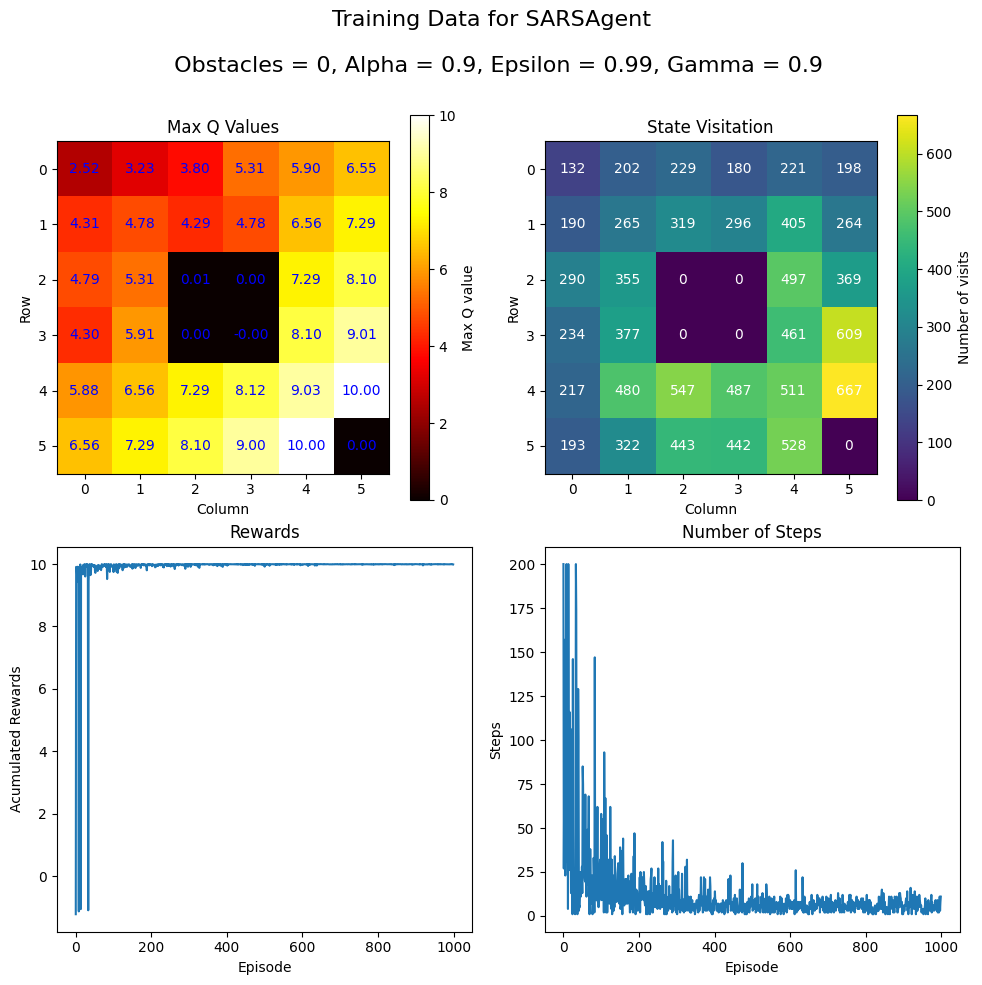

SARSAgent - 2 Obstacles - 0.99 Epsilon - 0.9 Gamma - 0.9 Alpha

Training Details:
+--------------------------+-----------+
|        Parameter         |   Value   |
+--------------------------+-----------+
|          Agent           | SARSAgent |
|       Approximator       |   False   |
|        Obstacles         |     2     |
|         Epsilon          |   0.99    |
|          Gamma           |    0.9    |
|          Alpha           |    0.9    |
|         Episodes         |   1000    |
| Execution Time (seconds) |   24.17   |
|      Success Count       |    966    |
+--------------------------+-----------+

Performance Metrics:
+------------+-------------+------------------------------+
|   Metric   |   Episode   |            Value             |
+------------+-------------+------------------------------+
| Max reward | Episode 68  |         reward = 10          |
| Min reward | Episode 466 | reward = -2.5000000000000013 |
| Max steps  |  Episode 2  |         steps = 200          |
| M

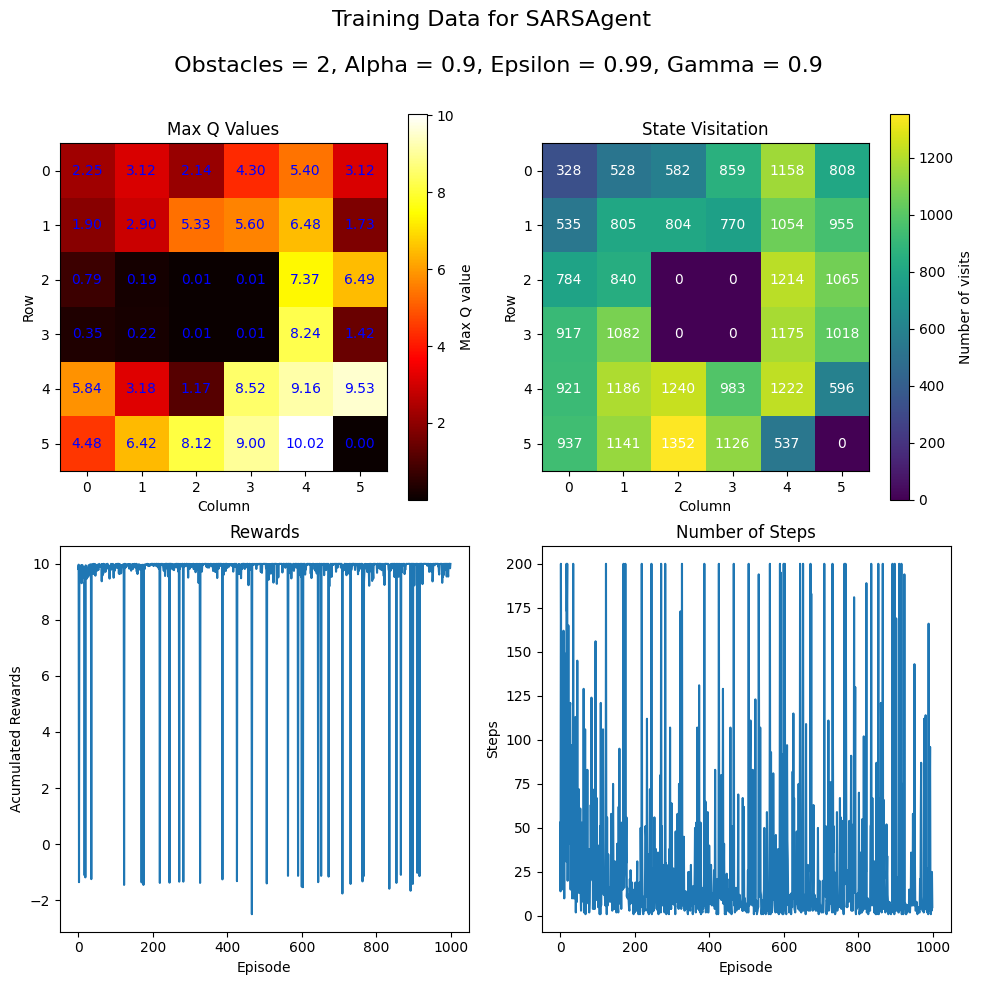

In [37]:
maze = 3
alpha = 0.9
gamma = 0.9
epsilon = 0.99
episodes = 1000
render = True
num_obstacles = 0
max_steps = 100
num_obstacles_list = [0,2]
param_grid = {
    'epsilon': [epsilon],
    'gamma': [gamma],
    'alpha': [alpha]
}
func = False



# agent.showQ()
# agent.execute_optimal_policy(max_steps = 500, start_pos=(0,0))
run_experiments(SARSAgent, maze, episodes, num_obstacles_list, param_grid, linear_approximator = func, save_plots=False, show_plots=True, render=render, max_steps = 200)
# results

# Deep Q-Networks

In [ ]:
import numpy as np
import gym
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import Model, layers

class DQNAgent:
    def __init__(self, env, state_shape, action_size):
        self.env = env
        self.state_shape = state_shape
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.success_count = 0
        self.state_visits = {}
        self.exploration_rate = []
        self.loss_history = []
        self.success_count_history = []
        self.t_episodes = 0

    def _build_model(self):
        # Building the neural network model
        inputs = layers.Input(shape=self.state_shape)
        layer1 = layers.Dense(24, activation='relu')(inputs)
        layer2 = layers.Dense(24, activation='relu')(layer1)
        outputs = layers.Dense(self.action_size, activation='linear')(layer2)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        # Copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(np.reshape(state, [1, *self.state_shape]))
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        # Verifica se há memória suficiente para o replay
        if len(self.memory) < batch_size:
            return

        # Seleciona uma amostra aleatória de experiências da memória
        minibatch = random.sample(self.memory, batch_size)

        # Extrai os estados atual e próximo de cada amostra
        no_state = np.zeros(self.state_shape)
        states = np.array([o[0] for o in minibatch])
        states_next = np.array([(no_state if o[3] is None else o[3]) for o in minibatch])

        # Redimensiona os estados para a forma esperada pelo modelo
        states = np.reshape(states, (batch_size, *self.state_shape))
        states_next = np.reshape(states_next, (batch_size, *self.state_shape))

        # Estima os valores Q para os estados atuais e os próximos estados
        q_vals = self.model.predict(states)
        q_vals_next = self.target_model.predict(states_next)

        # Prepara os dados de treinamento
        x = np.zeros((batch_size, *self.state_shape))
        y = np.zeros((batch_size, self.action_size))

        for i in range(batch_size):
            # Observação atual
            obs = minibatch[i]

            # Estado, Ação, Recompensa, Próximo Estado
            st = obs[0]; act = obs[1]; rew = obs[2]; st_next = obs[3]

            # Valores Q estimados para a observação
            t = q_vals[i]

            # Atualiza o alvo (target) para essa observação
            if st_next is None:
                t[act] = rew
            else:
                t[act] = rew + self.gamma * np.amax(q_vals_next[i])

            # Define os dados de treinamento
            x[i] = st
            y[i] = t

        # Treina o modelo com os dados
        history = self.model.fit(x, y, batch_size=batch_size, epochs=1, verbose=0)
        self.loss_history.append(history.history['loss'][0])

    def train(self, episodes, max_steps_per_episode=100, batch_size=32, render=False):
        self.t_episodes = episodes
        if render:
            self.env.InitializePygame()
        
        episodes_data = {}

        for episode in range(episodes):
            total_reward = 0
            state = self.env.reset()
            path = [state]
            state = np.array(state, dtype=np.float32)  # Converte o estado para o formato adequado
            state = np.reshape(state, [1, *self.state_shape])  # Redimensiona o estado
            done = False
            step_count = 0
            self.exploration_rate.append(self.epsilon)

            while not done and step_count < max_steps_per_episode:
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.array(next_state, dtype=np.float32)
                next_state = np.reshape(next_state, [1, *self.state_shape])
                path.append(next_state[0])
                self.remember(state, action, reward, next_state, done)

                state = next_state
                total_reward += reward
                step_count += 1

                if len(self.memory) > batch_size:
                    self.replay(batch_size)

                if render:
                    self.env.render()

            if done and step_count < max_steps_per_episode:
                self.success_count += 1
            else:
                total_reward += -10

            self.update_target_model()
            self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)

            episodes_data[episode] = {
                'reward': total_reward,
                'steps': step_count,
                'path': path
            }
            
            print(f"Episódio: {episode + 1}, Total de recompensas: {total_reward}, Epsilon: {self.epsilon:.2f}")

        if render:
            self.env.close()

        return episodes_data

In [ ]:
# Uso do agente para treinamento
env = MazeGameEnv(mazes[3])  # Ajuste aqui para o seu ambiente específico
state_size = (2,)  # Ajuste para o tamanho do estado do seu ambiente
action_size = env.action_space.n
agent = DQNAgent(env, state_size, action_size)

# Configurações de treinamento
episodes = 100  # Número de episódios para treinar
max_steps_per_episode = 100  # Máximo de passos por episódio
batch_size = 32  # Tamanho do lote para experiência replay
render = False  # Define se renderiza o ambiente durante o treinamento

# Treinamento do agente
episodes_data = agent.train(episodes, max_steps_per_episode, batch_size, render)

1/1 [==============================] - 0s 22ms/step
Episódio: 1, Total de recompensas: -10.226, Epsilon: 0.99
1/1 [==============================] - 0s 24ms/step
Episódio: 2, Total de recompensas: -10.433, Epsilon: 0.99
1/1 [==============================] - 0s 24ms/step
Episódio: 3, Total de recompensas: -10.388, Epsilon: 0.99
1/1 [==============================] - 0s 24ms/step
Episódio: 4, Total de recompensas: -10.388, Epsilon: 0.98
1/1 [==============================] - 0s 23ms/step
Episódio: 5, Total de recompensas: 9.817, Epsilon: 0.98
1/1 [==============================] - 0s 39ms/step
Episódio: 6, Total de recompensas: -10.325, Epsilon: 0.97
1/1 [==============================] - 0s 64ms/step
Episódio: 7, Total de recompensas: 9.856, Epsilon: 0.97
1/1 [==============================] - 0s 31ms/step
Episódio: 8, Total de recompensas: -10.325, Epsilon: 0.96
1/1 [==============================] - 0s 40ms/step
Episódio: 9, Total de recompensas: -10.343, Epsilon: 0.96
1/1 [=========

### Recompensa Total por Episódio

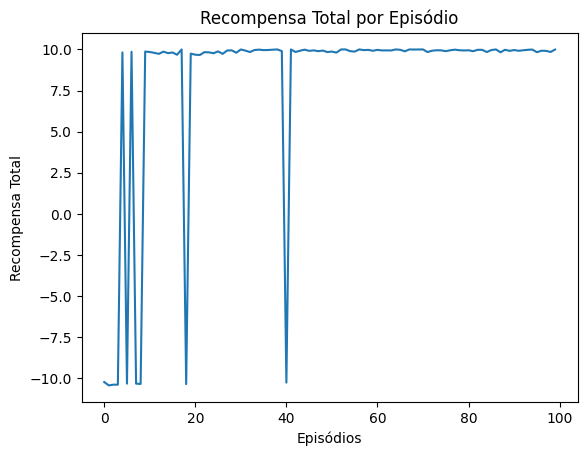

In [ ]:
rewards = [data['reward'] for data in episodes_data.values()]
plt.plot(rewards)
plt.title('Recompensa Total por Episódio')
plt.xlabel('Episódios')
plt.ylabel('Recompensa Total')
plt.show()

### Número de Passos por Episódio

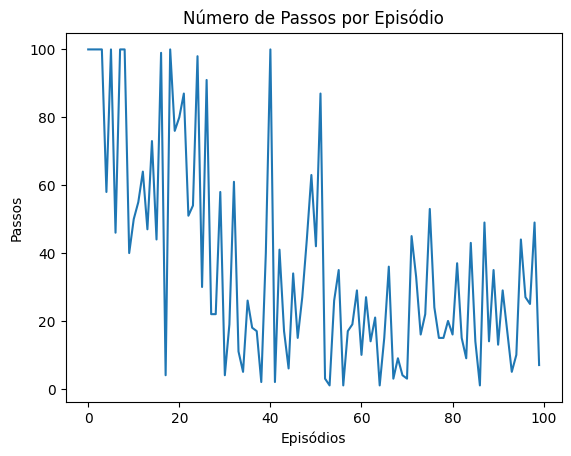

In [ ]:
steps = [data['steps'] for data in episodes_data.values()]
plt.plot(steps)
plt.title('Número de Passos por Episódio')
plt.xlabel('Episódios')
plt.ylabel('Passos')
plt.show()

### Taxa de Exploração (Epsilon) ao Longo dos Episódios

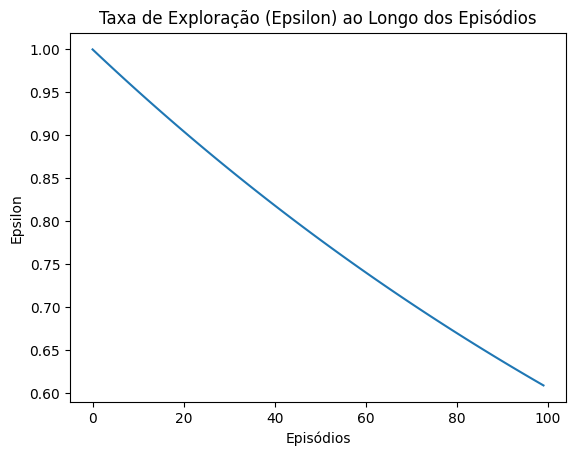

In [ ]:
plt.plot(agent.exploration_rate)
plt.title('Taxa de Exploração (Epsilon) ao Longo dos Episódios')
plt.xlabel('Episódios')
plt.ylabel('Epsilon')
plt.show()

### Loss por Episódio

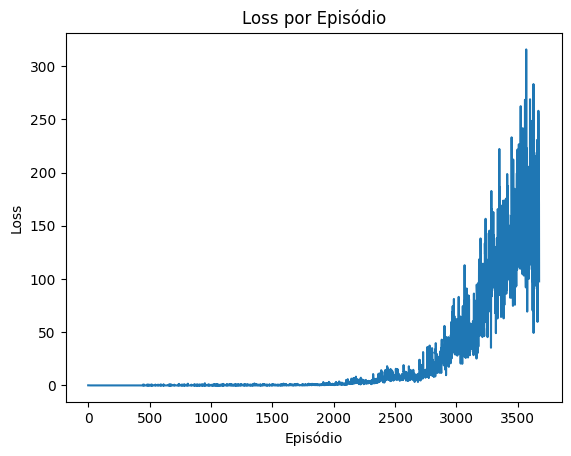

In [ ]:
plt.plot(agent.loss_history)
plt.title('Loss por Episódio')
plt.xlabel('Episódio')
plt.ylabel('Loss')
plt.show()